# Libraries & global variables

In [1]:
import warnings
import logging
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import gc
import math
import pandas as pd
from datetime import datetime

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

DATA_SOURCE_DIR = '/kaggle/input/hw2-dataset'
DATA_SOURCE = os.path.join(DATA_SOURCE_DIR, 'mars_for_students_cleaned.npz')

SEED = 12

np.random.seed(SEED)
random.seed(SEED)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as K
from keras import layers as L
from keras import models as M
from keras import backend as B
from keras.saving import register_keras_serializable

# Set seed for TensorFlowimage
tf.random.set_seed(SEED)
tf.compat.v1.set_random_seed(SEED)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

2.16.1


# Data

In [2]:
data = np.load(DATA_SOURCE)
print("Keys: ", data.keys())

Keys:  KeysView(NpzFile '/kaggle/input/hw2-dataset/mars_for_students_cleaned.npz' with keys: training_set, test_set)


In [3]:
#train_valid_data = np.concatenate((
#    data['cutmix_set'],
#    data['ftr_set'],
#    data['color_set'],
#    data['big_rock_set']
#), axis=0)
train_valid_data = data['training_set']
test_data = data['test_set']
print(train_valid_data.shape)
print(train_valid_data.dtype)
print(test_data.shape)
print(test_data.dtype)

(2505, 2, 64, 128)
float64
(10022, 64, 128)
uint8


In [4]:
def split(data, target=None, ratio=0.2, seed=None):
    if seed is None:
        seed = np.random.randint(0, 1000000)
    np.random.seed(seed)
    size = len(data)
    indices = np.arange(size)
    indices = np.random.permutation(indices)
    split = int(size * (1 - ratio))
    if target is None:
        return data[indices[:split]], data[indices[split:]]
    return data[indices[:split]], target[indices[:split]], data[indices[split:]], target[indices[split:]]

In [5]:
train_data, valid_data = split(train_valid_data, ratio=0.2, seed=SEED)

img_train = train_data[:, 0, :, :]
if len(img_train.shape) < 4:
    img_train = img_train[..., np.newaxis] / 255.0
msk_train = train_data[:, 1, :, :]
if len(msk_train.shape) < 4:
    msk_train = msk_train[..., np.newaxis]

img_valid = valid_data[:, 0, :, :]
if len(img_valid.shape) < 4:
    img_valid = img_valid[..., np.newaxis] / 255.0
msk_valid = valid_data[:, 1, :, :]
if len(msk_valid.shape) < 4:
    msk_valid = msk_valid[..., np.newaxis]

img_test = test_data

DATA_SHAPE = img_train.shape[1:]
NUM_CLASSES = len(np.unique(msk_train))
print(DATA_SHAPE)
print(NUM_CLASSES)

print(f"IMG: {img_train.shape}, {img_train.dtype}\n{img_train[0][0][:3]}")
print(f"MSK: {msk_train.shape}, {msk_train.dtype}\n{msk_train[0][0][:3]}")

(64, 128, 1)
5
IMG: (2004, 64, 128, 1), float64
[[0.12156863]
 [0.12156863]
 [0.12156863]]
MSK: (2004, 64, 128, 1), float64
[[3.]
 [3.]
 [3.]]


# Losses

In [6]:
@register_keras_serializable()
class CustomDiceLoss(K.losses.Loss):
    def __init__(self, labels_to_exclude=[0], name="custom_dice_loss", smooth=None, **kwargs):
        super().__init__(name=name, **kwargs)
        self.labels_to_exclude = labels_to_exclude
        self.smooth = smooth or 1.

    def call(self, y_true, y_pred):        
        y_true = tf.one_hot(tf.cast(y_true, tf.uint8), depth=tf.shape(y_pred)[-1])
        # Both are one-hot encoded at this point
        y_true_flat = tf.reshape(y_true, [-1, tf.shape(y_true)[-1]])
        y_pred_flat = tf.reshape(y_pred, [-1, tf.shape(y_pred)[-1]])
        
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true_flat, label)
            y_true_flat = tf.boolean_mask(y_true_flat, mask)
            y_pred_flat = tf.boolean_mask(y_pred_flat, mask)
        
        intersection = tf.math.reduce_sum(y_true_flat * y_pred_flat, axis=0)
        total = tf.math.reduce_sum(y_true_flat, axis=0) + tf.math.reduce_sum(y_pred_flat, axis=0)

        dice = (2. + intersection + self.smooth) / (total + self.smooth)

        # Return the Dice loss
        return 1. - tf.reduce_mean(dice)

In [7]:
@register_keras_serializable()
class CustomFocalTverskyLoss(K.losses.Loss):
    def __init__(self, labels_to_exclude=[0], name="custom_focal_tversky_loss", smooth=None, alpha=None, gamma=None, **kwargs):
        super().__init__(name=name, **kwargs)
        self.labels_to_exclude = labels_to_exclude
        self.alpha = alpha or 0.5
        self.gamma = gamma or 1.
        self.smooth = smooth or 1.

    def call(self, y_true, y_pred):        
        y_true = tf.one_hot(tf.cast(y_true, tf.uint8), depth=tf.shape(y_pred)[-1])
        # Both are one-hot encoded at this point
        y_true_flat = tf.reshape(y_true, [-1, tf.shape(y_true)[-1]])
        y_pred_flat = tf.reshape(y_pred, [-1, tf.shape(y_pred)[-1]])
        
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true_flat, label)
            y_true_flat = tf.boolean_mask(y_true_flat, mask)
            y_pred_flat = tf.boolean_mask(y_pred_flat, mask)
        
        tp = tf.math.reduce_sum(y_true_flat * y_pred_flat, axis=0)
        fp = tf.math.reduce_sum((1. - y_true_flat) * y_pred_flat, axis=0)
        fn = tf.math.reduce_sum(y_true_flat * (1. - y_pred_flat), axis=0)

        tversky_index = (tp + self.smooth) / (tp + self.alpha * fn + (1. - self.alpha) * fp + K.epsilon())

        return 1. - tf.reduce_mean(tversky_index)

# Hyperparameters

In [8]:
# Set batch size for training
BATCH_SIZE = 16

# Set learning rate for the optimiser
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
FM_DECAY = 850./1000.
SM_DECAY = 950./1000.

# Define a learning rate scheduler
STEPS_PER_EPOCH = img_train.shape[0] // BATCH_SIZE
DECAY_AFTER_EPOCHS = 50
DECAY_RATE = 70./100.
DECAY = K.optimizers.schedules.ExponentialDecay(
    LEARNING_RATE, decay_steps=DECAY_AFTER_EPOCHS * STEPS_PER_EPOCH, decay_rate=DECAY_RATE, staircase=True)

# Define the optimizer
OPTIMIZER = K.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    beta_1=FM_DECAY,
    beta_2=SM_DECAY,
    epsilon=K.backend.epsilon()
)

# Define the loss function
LOSS=CustomDiceLoss(labels_to_exclude=[0])

# Define the metrics
METRICS=[K.metrics.MeanIoU(num_classes=NUM_CLASSES, ignore_class=0, sparse_y_pred=False, name='mean_iou')]

# Set early stopping patience threshold
PATIENCE = 100

# Set maximum number of training epochs
EPOCHS = 1000

# Which measure to monitor?
MONITOR = 'val_mean_iou'
MONITOR_MODE = 'max'

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices((img_train, msk_train))
train_dataset = train_dataset.map(lambda img, msk: (img, tf.squeeze(msk, axis=-1)), num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=BATCH_SIZE * 2, seed=SEED, reshuffle_each_iteration=True)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=False, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

valid_dataset = tf.data.Dataset.from_tensor_slices((img_valid, msk_valid))
valid_dataset = valid_dataset.map(lambda img, msk: (img, tf.squeeze(msk, axis=-1)), num_parallel_calls=tf.data.AUTOTUNE)
valid_dataset = valid_dataset.shuffle(buffer_size=BATCH_SIZE * 2, seed=SEED, reshuffle_each_iteration=False)
valid_dataset = valid_dataset.batch(BATCH_SIZE, drop_remainder=False, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

## Visual things (100% copied)

In [10]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

def plot_sample_batch(dataset, num_samples=3):
    """
    Display some image and label pairs from the dataset.
    """
    plt.figure(figsize=(15, 4*num_samples))

    for images, labels in dataset.take(1):
        labels_np = labels.numpy()
        labels_np = labels_np[..., np.newaxis]
        num_classes = len(np.unique(labels_np))
        colormap = create_segmentation_colormap(num_classes)

        for j in range(min(num_samples, len(images))):
            # Plot original image
            plt.subplot(num_samples, 2, j*2 + 1)
            plt.imshow(images[j])
            plt.title(f'Image {j+1}')
            plt.axis('off')

            # Plot colored label
            plt.subplot(num_samples, 2, j*2 + 2)
            colored_label = apply_colormap(labels_np[j], colormap)
            plt.imshow(colored_label)
            plt.title(f'Label {j+1}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()

# My embeddings do not work at all (am I so dumb?)

In [11]:
class PatchEmbeddings(L.Layer):
    def __init__(self, embed_dim, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.patch_size = patch_size
        
    def build(self, input_shape):
        patch_area = self.patch_size * self.patch_size * input_shape[-1]
        self.W = self.add_weight(
            shape=(patch_area, self.embed_dim),
            initializer='glorot_uniform',
            trainable=True
        )
        self.b = self.add_weight(
            shape=(self.embed_dim, ),
            initializer='zeros',
            trainable=True
        )

    def call(self, inputs):
        #batch_size, _, _, channels = tf.shape(inputs)
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        channels = input_shape[-1]
        patches = tf.image.extract_patches(
            images=inputs,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        patch_area = self.patch_size * self.patch_size * channels
        patches = tf.reshape(patches, [batch_size, -1, patch_area])
        patch_embeddings = tf.linalg.matmul(patches, self.W) + self.b
        return patch_embeddings

class PositionalEmbeddings(L.Layer):
    def __init__(self, embed_dim, num_patches, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_patches = num_patches

    def build(self, input_shape):
        self.W = self.add_weight(
            shape=(1, self.num_patches, self.embed_dim),
            initializer='glorot_uniform',
            trainable=True
        )

    def call(self):
        return self.W

# Stolen (but possibly working) embeddings

In [12]:
@register_keras_serializable()
class Patches(L.Layer):
    # It takes a batch of images and returns a batch of patches
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = tf.shape(patches)[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

@register_keras_serializable()
class PatchEncoder(L.Layer):
    # It takes patches and projects them into a `projection_dim` dimensional space, then the position embedding is added
    def __init__(self, num_patches, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.projection = L.Dense(units=projection_dim)
        self.position_embedding = L.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

# ViT

In [13]:
@register_keras_serializable()
class MLP(L.Layer):
    def __init__(self, input_dim, output_dim, dropout_rate=None, hidden_activation=None, output_activation=None, **kwargs):
        super().__init__(**kwargs)
        self.hidden_layer = L.Dense(input_dim, activation=hidden_activation)
        self.dropout = L.Dropout(dropout_rate) if dropout_rate is not None else None
        self.output_layer = L.Dense(output_dim, activation=output_activation)

    def call(self, x):
        x = self.hidden_layer(x)
        x = self.dropout(x) if self.dropout is not None else x
        x = self.output_layer(x)
        return x

@register_keras_serializable()
class TransformerEncoder(L.Layer):
    def __init__(self, num_heads, embed_dim, mlp_dim, dropout_rate=None, activation=None, **kwargs):
        super().__init__(**kwargs)
        activation = activation or 'relu'
        self.norm1 = L.LayerNormalization(epsilon=B.epsilon())
        self.attention = L.MultiHeadAttention(num_heads, embed_dim)
        self.dropout1 = L.Dropout(dropout_rate) if dropout_rate is not None else None
        self.res_add1 = L.Add()
        self.norm2 = L.LayerNormalization(epsilon=B.epsilon())
        self.mlp = MLP(
            input_dim=mlp_dim,
            output_dim=embed_dim,
            dropout_rate=dropout_rate,
            hidden_activation=activation
        )
        self.dropout2 = L.Dropout(dropout_rate) if dropout_rate is not None else None
        self.res_add2 = L.Add()

    def call(self, x):
        skip = x
        x = self.norm1(x)
        attn = self.attention(x, x)
        x = self.dropout1(attn) if self.dropout1 is not None else x
        x = self.res_add1([x, skip])
        skip = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = self.dropout2(x) if self.dropout2 is not None else x
        x = self.res_add2([x, skip])
        return x

# Auto-fusion

In [14]:
@register_keras_serializable()
class Gate(L.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.x_weight_compute = L.Dense(1, activation='sigmoid')
        self.y_weight_compute = L.Dense(1, activation='sigmoid')
        self.x_weight_apply = L.Multiply()
        self.y_weight_apply = L.Multiply()
        self.add = L.Add()

    def call(self, x, y):
        w_x = self.x_weight_compute(x)
        w_y = self.y_weight_compute(y)
        x = self.x_weight_apply([x, w_x])
        y = self.y_weight_apply([y, w_y])
        combination = self.add([x, y])
        return combination

# BBB (Basic Building Blocks)

In [15]:
@register_keras_serializable()
class ConvBlock(L.Layer):
    def __init__(self, kernels, stack, activation, dropout_rate=None, batch_norm=None, dilation_rate=1, **kwargs):
        super().__init__(**kwargs)
        self.stack = stack
        self.convs = [L.Conv2D(filters=kernels, kernel_size=3, padding='same', dilation_rate=dilation_rate) for _ in range(stack)]
        self.norms = [L.BatchNormalization(epsilon=B.epsilon()) for _ in range(stack)] if batch_norm is not None else None
        self.fns = [L.Activation(activation) for _ in range(stack)]
        self.dropouts = [L.Dropout(dropout_rate) for _ in range(stack)] if dropout_rate is not None else None

    def call(self, x):
        for i in range(self.stack):
            x = self.convs[i](x)
            x = self.norms[i](x) if self.norms is not None else x
            x = self.fns[i](x)
            x = self.dropouts[i](x) if self.dropouts is not None else x
        return x

In [16]:
@register_keras_serializable()
class UpsampleBlock(L.Layer):
    def __init__(self, kernels, **kwargs):
        super().__init__(**kwargs)
        self.up = L.Conv2DTranspose(filters=kernels, kernel_size=2, strides=2, padding='same')

    def call(self, x):
        x = self.up(x)
        return x

In [17]:
@register_keras_serializable()
class SkipBlock(L.Layer):
    def __init__(self, kernels, stack, activation, dropout_rate=None, batch_norm=None, **kwargs):
        super().__init__(**kwargs)
        self.up = UpsampleBlock(kernels)
        self.convs = ConvBlock(kernels, stack, activation, dropout_rate, batch_norm)

    def call(self, x):
        x = self.up(x)
        x = self.convs(x)
        return x

In [18]:
@register_keras_serializable()
class DownsampleBlock(L.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.down = L.MaxPooling2D()

    def call(self, x):
        x = self.down(x)
        return x

In [19]:
@register_keras_serializable()
class SqueezeAndExcitation(L.Layer):
    def __init__(self, channels, ratio, activation, **kwargs):
        super().__init__(**kwargs)
        self.gap = L.GlobalAveragePooling2D()
        self.squeeze = L.Dense(units=channels//ratio, activation=activation)
        self.weight = L.Dense(units=channels, activation='sigmoid')
        self.scale = L.Reshape((1, 1, channels))
        self.excite = L.Multiply()

    def call(self, x):
        y = self.gap(x)
        y = self.squeeze(y)
        y = self.weight(y)
        y = self.scale(y)
        z = self.excite([x, y])
        return z

# The model: TA-DAH! (Sry, apparently I wasn't able to inherit keras.Model the correct way)

In [20]:
class UNeTr():
    def __init__(
        self,
        input_shape, # "libero"
        patch_size, # dipende dal numero di decoder! 2^num_dec -> num_dec=log2(patch_size)
        embed_dim, # libero
        encoding_layers, # libero
        num_heads, # libero
        mlp_dim, # libero
        mlp_activation, # libero
        #decoding_layers, # dipende dalla dimensione della patch! log2(patch_size)
        conv_stack, # libero
        kernels, # libero
        kernel_init, # libero
        conv_activation, # libero
        num_classes, # fissato dal problema
        input_propagation_dilation_rate,
        dropout_rate, # libero
        batch_norm # libero
    ):
        self.input_shape = input_shape
        self.patches = Patches(patch_size, name='PatchExtractor')
        height, width, channels = input_shape
        num_patches = (height // patch_size) * (width // patch_size) * channels
        self.num_patches = num_patches
        decoding_layers = int(math.log2(patch_size))
        self.decoding_layers = decoding_layers
        self.encoded_patches = PatchEncoder(num_patches, embed_dim, name='Embeddings')
        self.input_propagation = ConvBlock(kernels, conv_stack, conv_activation, dropout_rate, batch_norm, input_propagation_dilation_rate, name='InputPropagation')
        self.intermediate_encoding_output_indices = [encoding_layers - 1 - (encoding_layers // decoding_layers) * i for i in range(decoding_layers)]
        self.encoders = [TransformerEncoder(num_heads, embed_dim, mlp_dim, activation=mlp_activation, dropout_rate=dropout_rate, name=f'Transformer_{i+1}') for i in range(encoding_layers)]
        self.reshape_layers = [L.Reshape([height // patch_size, width // patch_size, embed_dim], name=f'Reshape_{i+1}') for i in range(decoding_layers)]
        self.up_layers = [UpsampleBlock(kernels * (2 ** (decoding_layers - i - 1)), name=f'Deconv_{i+1}') for i in range(decoding_layers)]
        self.skip_blocks = [
            [
                SkipBlock(
                    kernels * (2 ** (decoding_layers - i - 1)),
                    conv_stack,
                    conv_activation,
                    dropout_rate,
                    batch_norm,
                    name=f'Skip_{j+1}_{i+1}'
                ) for i in range(j)
            ] for j in range(1, decoding_layers) # exclude the bottleneck
        ]
        self.gates = [Gate(name=f'Gate_{i+1}') for i in range(decoding_layers)]
        self.decoders = [ConvBlock(kernels * (2 ** (decoding_layers - i - 1)), conv_stack, conv_activation, dropout_rate, batch_norm, name=f'Decoder_{i+1}') for i in range(decoding_layers)]
        self.output_layer = L.Conv2D(filters=num_classes, kernel_size=1, padding='same', activation='softmax', name=f'OutputConv')

    def build(self):
        input = L.Input(self.input_shape)
        # ENCODER
        x = input
        x = self.patches(x)
        x = self.encoded_patches(x)
        es = [] # where to store intermediate encoder output
        for i, encoder in enumerate(self.encoders):
            e = encoder(x)
            es.append(e)
        es = [es[i] for i in self.intermediate_encoding_output_indices] # keep only "important" ones
        es = [reshape_layer(e) for reshape_layer, e in zip(self.reshape_layers, es)]
        # BOTTLENECK
        bottleneck = self.up_layers[0](es[0])
        # SKIP CONNECTIONS
        skip_connections = []
        for skip_block, e in zip(self.skip_blocks, es[1:]):
            partial = e
            for skip_layer in skip_block:
                partial = skip_layer(partial)
            skip_connections.append(partial)
            
        # The first output joins the bottleneck with the first skip connection, then the upsampled previous output (after decoding) and the corresponding skip
        gate_outputs = []
        for i in range(self.decoding_layers):
            if i == 0:
                prev_output = bottleneck
            else:
                prev_output = self.up_layers[i](self.decoders[i - 1](gate_outputs[i - 1]))
    
            output = self.gates[i](
                prev_output,
                skip_connections[i] if i < self.decoding_layers - 1 else self.input_propagation(input)
            )
            gate_outputs.append(output)

        #gate_1 = self.gates[0](bottleneck, skip_connections[0])
        #gate_2 = self.gates[1](self.up_layers[1](self.decoders[0](gate_1)), skip_connections[1])
        #gate_3 = self.gates[2](self.up_layers[2](self.decoders[1](gate_2)), skip_connections[2])
        #gate_4 = self.gates[3](self.up_layers[3](self.decoders[2](gate_3)), self.input_propagation(input))

        # Why can't I use the list in its definition? Oh well, it's not the language of gods (Haskell)
        #gate_outputs = [
        #    gate(
        #        self.up_layers[i](self.decoders[i - 1](gate_outputs[i - 1])) if i > 0 else self.up_layers[0](es[0]),
        #        skip_connections[i] if i < len(self.gates) - 1 else self.input_propagation(input)
        #    ) for i, gate in enumerate(self.gates)
        #]

        last_decode = self.decoders[-1](gate_outputs[-1])
        
        output = self.output_layer(last_decode)
        return M.Model(inputs=input, outputs=output, name='UNeTR')

The next model does not work: it's a last-day-try, but there's an error in skip connections. \
In particular, shapes do not match.

In [21]:
class UNet():
    def __init__(
        self,
        input_shape,
        depth,
        top_patch_size,
        transformer_layers,
        num_heads,
        mlp_activation,
        conv_stack,
        top_kernels,
        kernel_init,
        conv_activation,
        se_ratio,
        se_activation,
        num_classes,
        dropout_rate,
        batch_norm
    ):
        height, width, channels = input_shape
        scale_factor = [(2 ** i) for i in range(depth)]
        print(scale_factor)
        num_patches = [(height // (top_patch_size // scale_factor[i])) * (width // (top_patch_size // scale_factor[i])) * (top_kernels * scale_factor[i]) for i in range(depth)]
        print(num_patches)
        embed_dim = [(height // scale_factor[i]) * (width // scale_factor[i]) * scale_factor[i] for i in range(depth)]
        print(embed_dim)
        self.input = L.Input(input_shape, name='Input')
        self.encoder = [ConvBlock(top_kernels * scale_factor[i], conv_stack, conv_activation, dropout_rate, batch_norm, name=f'Encoder_{i+1}') for i in range(depth)]
        self.downsampler = [DownsampleBlock(name=f'Downsample_{i+1}') for i in range(depth)]
        self.bottleneck = SqueezeAndExcitation(channels=(top_kernels * scale_factor[-1]), ratio=se_ratio, activation=se_activation, name='Bottleneck_SE')
        self.decoder = [ConvBlock(top_kernels * scale_factor[i], conv_stack, conv_activation, dropout_rate, batch_norm, name=f'Decoder_{i+1}') for i in range(depth)]
        self.upsampler = [UpsampleBlock(top_kernels * scale_factor[i], name=f'Upsample_{i+1}') for i in range(depth)]
        self.patch_extractor = [Patches(top_patch_size // scale_factor[i], name=f'PatchExtractor_{i+1}') for i in range(depth)]
        self.embedding = [PatchEncoder(num_patches[i], embed_dim[i], name=f'Embeddings_{i+1}') for i in range(depth)]
        self.transformer = [TransformerEncoder(num_heads, embed_dim[i], 4 * embed_dim[i], activation=mlp_activation, dropout_rate=dropout_rate, name=f'Transformer_{i+1}') for i in range(depth)]
        self.reshape = [L.Reshape([height // scale_factor[i], width // scale_factor[i], -1], name=f'Reshape_{i+1}') for i in range(depth)]
        self.gate = [Gate(name=f'Gate_{i+1}') for i in range(depth)]
        self.output = L.Conv2D(filters=num_classes, kernel_size=1, padding='same', activation='softmax', name='Output')

    def build(self):
        # Input
        input = self.input
        x = input
        # Encoders
        enc_out = []
        down_out = []
        for encoder, downsampler in zip(self.encoder, self.downsampler):
            x = encoder(x)
            enc_out.append(x)
            x = downsampler(x)
            down_out.append(x)
        # Bottleneck
        x = self.bottleneck(x)
        # Skip connections
        skip = []
        for input, patch, embedding, transformer, reshape in zip(enc_out, self.patch_extractor, self.embedding, self.transformer, self.reshape):
            s = patch(input)
            s = embedding(s)
            s = transformer(s)
            s = reshape(s)
            skip.append(s)
        # Decoders
        for skip, gate, upsampler, decoder in zip(reversed(skip), self.gate, reversed(self.upsampler), reversed(self.decoder)):
            x = upsampler(x)
            x = gate(x, skip)
            x = decoder(x)
        # Output
        output = self.output(x)
        return M.Model(inputs=input, outputs=output, name='UNet')

Model: "UNeTR"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 128,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PatchExtractor      │ (None, None, 256) │          0 │ input_layer[0][0] │
│ (Patches)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Embeddings          │ (None, 32, 768)   │    221,952 │ PatchExtractor[0… │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Transformer_12      │ (None, 32, 768)   │ 14,172,672 │ Embeddings[0][0]  │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Transformer_9       │ (None, 32, 768)   │ 14,172,672 │ Embeddings[0][0]  │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Reshape_1 (Reshape) │ (None, 4, 8, 768) │          0 │ Transformer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Reshape_2 (Reshape) │ (None, 4, 8, 768) │          0 │ Transformer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Deconv_1            │ (None, 8, 16,     │    393,344 │ Reshape_1[0][0]   │
│ (UpsampleBlock)     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Skip_2_1            │ (None, 8, 16,     │    689,536 │ Reshape_2[0][0]   │
│ (SkipBlock)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Transformer_6       │ (None, 32, 768)   │ 14,172,672 │ Embeddings[0][0]  │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Gate_1 (Gate)       │ (None, 8, 16,     │        258 │ Deconv_1[0][0],   │
│                     │ 128)              │            │ Skip_2_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Reshape_3 (Reshape) │ (None, 4, 8, 768) │          0 │ Transformer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_1           │ (None, 8, 16,     │    296,192 │ Gate_1[0][0]      │
│ (ConvBlock)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Skip_3_1            │ (None, 8, 16,     │    689,536 │ Reshape_3[0][0]   │
│ (SkipBlock)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Transformer_3       │ (None, 32, 768)   │ 14,172,672 │ Embeddings[0][0]  │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Deconv_2            │ (None, 16, 32,    │     32,832 │ Decoder_1[0][0]   │
│ (UpsampleBlock)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Skip_3_2            │ (None, 16, 32,    │    107,200 │ Skip_3_1[0][0]    │
│ (SkipBlock)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Reshape_4 (Reshape) │ (None, 4, 8, 768) │          0 │ Transformer_3[0]

 Total params: 60,056,349 (229.10 MB)

 Trainable params: 60,053,149 (229.08 MB)

 Non-trainable params: 3,200 (12.50 KB)

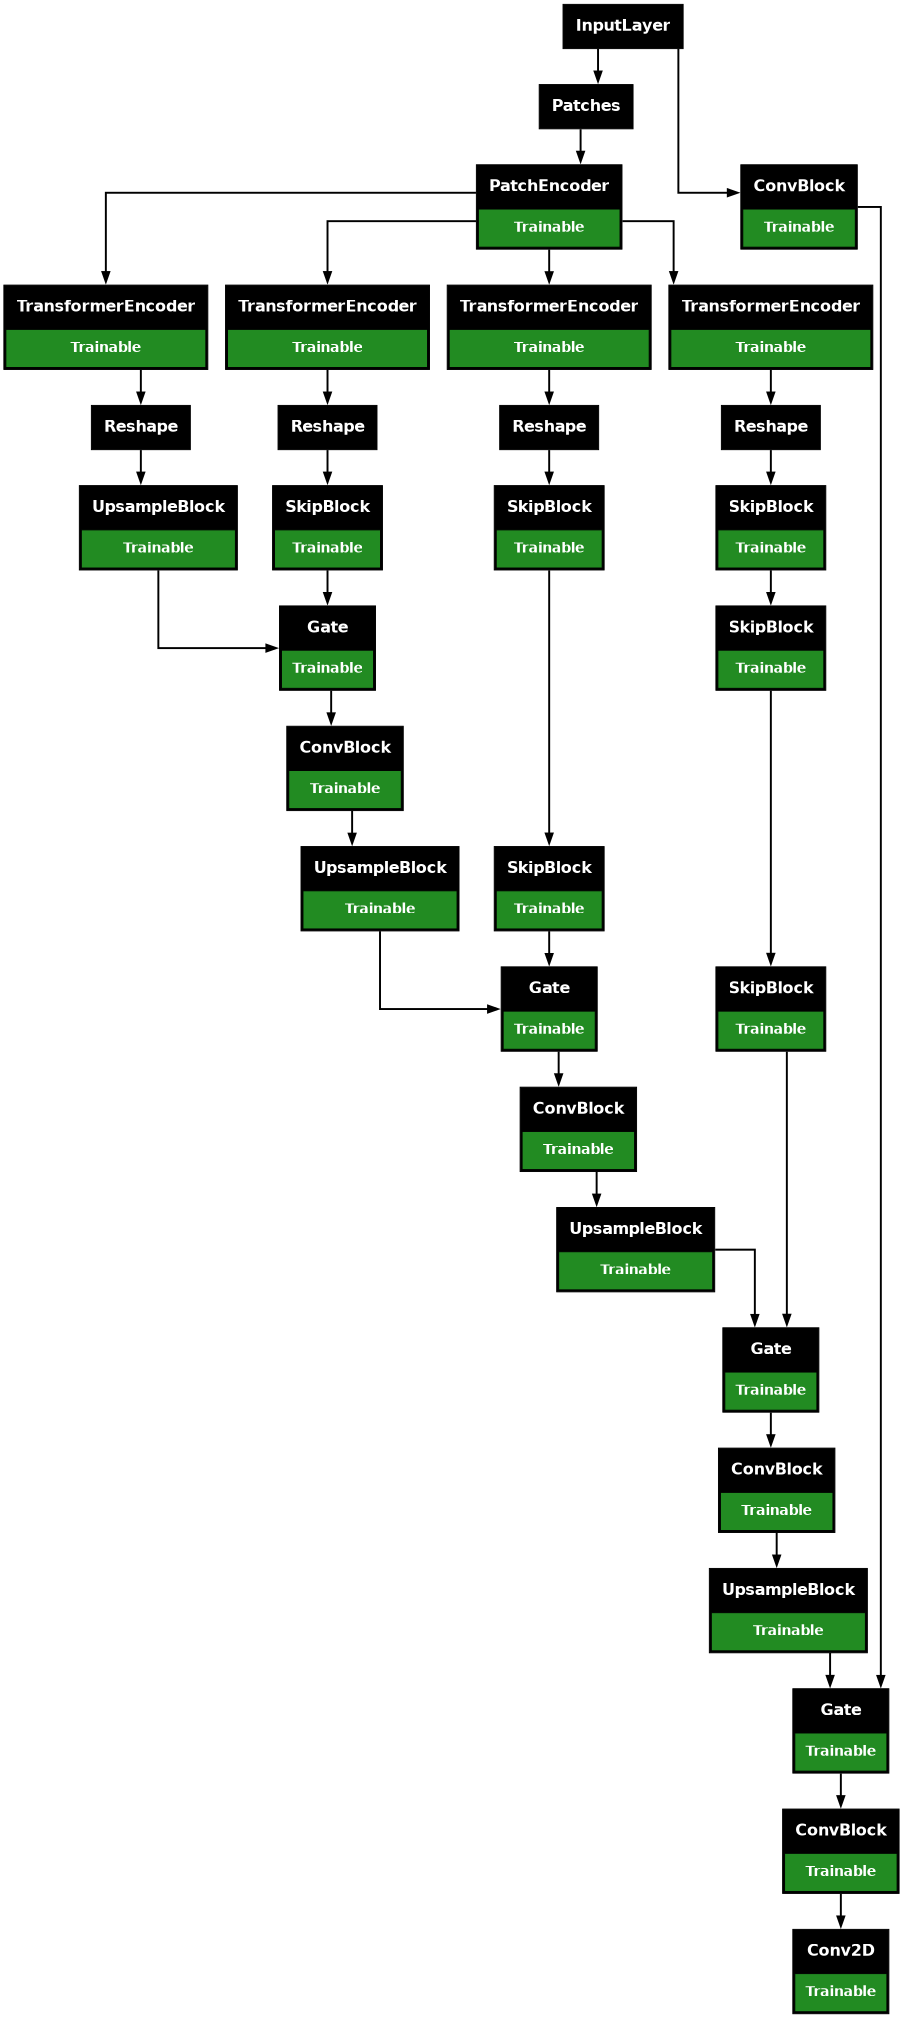

In [22]:
unetr = UNeTr(
    input_shape=DATA_SHAPE,
    patch_size=16,
    embed_dim=768,
    encoding_layers=12,
    num_heads=4,
    mlp_dim=768*4,
    mlp_activation='swish',
    #decoding_layers=4,
    conv_stack=2,
    kernels=16,
    kernel_init='he_normal',
    conv_activation='swish',
    num_classes=NUM_CLASSES,
    input_propagation_dilation_rate=2,
    dropout_rate=0.1,
    batch_norm=True
)

#unet = UNet(
#    input_shape=DATA_SHAPE,
#    depth=4,
#    top_patch_size=32,
#    transformer_layers=4,
#    num_heads=4,
#    mlp_activation='swish',
#    conv_stack=2,
#    top_kernels=32,
#    kernel_init='he_normal',
#    conv_activation='swish',
#    se_ratio=16,
#    se_activation='swish',
#    num_classes=NUM_CLASSES,
#    dropout_rate=0.1,
#    batch_norm=True
#)

model = unetr.build()
model.summary()
K.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

# Callbacks (50% copied)

In [23]:
# Visualization callback
class VizCallback(K.callbacks.Callback):
    def __init__(self, image, mask, frequency=5):
        super().__init__()
        self.image = image
        self.mask = mask
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image = self.image
            mask = self.mask
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            num_classes = NUM_CLASSES
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0])
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_mask = apply_colormap(mask, colormap)
            plt.imshow(colored_mask)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

In [24]:
class LearningRateLogger(K.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        # Fetch the learning rate from the optimizer
        lr = self.model.optimizer.learning_rate
        if isinstance(lr, K.optimizers.schedules.LearningRateSchedule):
            # If the learning rate is a schedule, get its current value
            lr = lr(tf.cast(epoch, tf.float32))
        print(f"Epoch {epoch + 1}: Learning rate is {tf.keras.backend.get_value(lr)}")

In [25]:
# Setup callbacks
early_stopping = K.callbacks.EarlyStopping(
    monitor=MONITOR,
    mode=MONITOR_MODE,
    patience=PATIENCE,
    restore_best_weights=True
)

viz_callback = VizCallback(img_valid[0], msk_valid[0])

lr_logger = LearningRateLogger()

CALLBACKS = [early_stopping, viz_callback, lr_logger]

# Train hard or die harder

In [26]:
# Compile the model
print("Compiling model...")
model.compile(
    loss=LOSS,
    optimizer=OPTIMIZER,
    metrics=METRICS
)
print("Model compiled!")

Compiling model...
Model compiled!


Epoch 1: Learning rate is 9.999999747378752e-05
Epoch 1/1000


I0000 00:00:1734201208.166493      89 service.cc:145] XLA service 0x7f8d98003fa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734201208.166550      89 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1734201302.550684      89 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_103', 8 bytes spill stores, 32 bytes spill loads

I0000 00:00:1734201302.650924      89 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.8156 - mean_iou: 0.1150

I0000 00:00:1734201393.861334      89 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_85', 120 bytes spill stores, 192 bytes spill loads
ptxas warning : Registers are spilled to local memory in function '__cuda_sm3x_div_rn_noftz_f32_slowpath', 44 bytes spill stores, 44 bytes spill loads



126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 731ms/step - loss: 0.8155 - mean_iou: 0.1151

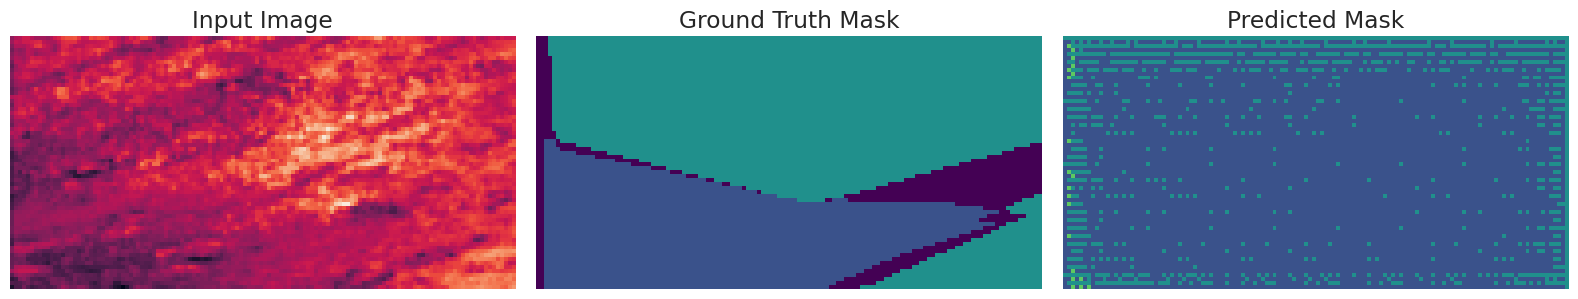

126/126 ━━━━━━━━━━━━━━━━━━━━ 237s 926ms/step - loss: 0.8154 - mean_iou: 0.1151 - val_loss: 0.8280 - val_mean_iou: 0.1570
Epoch 2: Learning rate is 9.999999747378752e-05
Epoch 2/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.7741 - mean_iou: 0.1785 - val_loss: 0.8022 - val_mean_iou: 0.1600
Epoch 3: Learning rate is 9.999999747378752e-05
Epoch 3/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.7385 - mean_iou: 0.2130 - val_loss: 0.7260 - val_mean_iou: 0.2125
Epoch 4: Learning rate is 9.999999747378752e-05
Epoch 4/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.7180 - mean_iou: 0.2364 - val_loss: 0.7836 - val_mean_iou: 0.1230
Epoch 5: Learning rate is 9.999999747378752e-05
Epoch 5/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.7086 - mean_iou: 0.2342 - val_loss: 0.7383 - val_mean_iou: 0.2057
Epoch 6: Learning rate is 9.999999747378752e-05
Epoch 6/1000
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.6973 - mean_iou: 0.2428

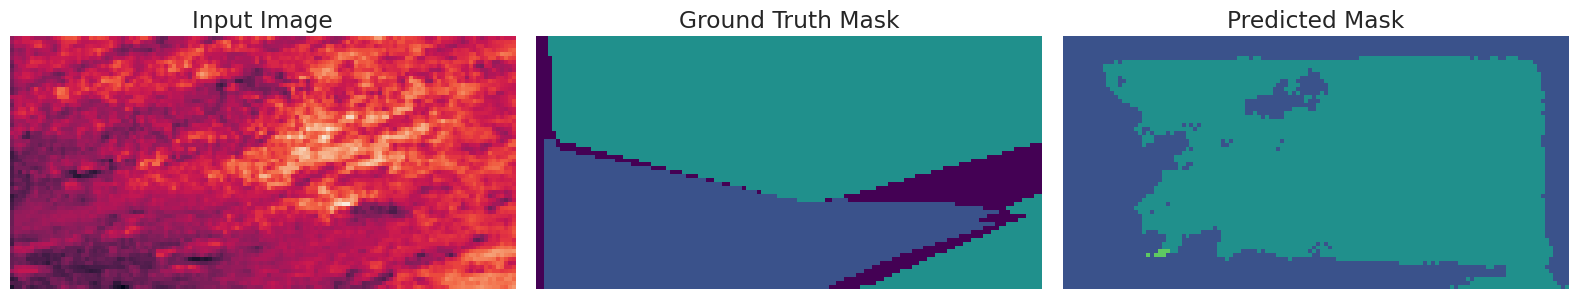

126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.6973 - mean_iou: 0.2426 - val_loss: 0.7705 - val_mean_iou: 0.1342
Epoch 7: Learning rate is 9.999999747378752e-05
Epoch 7/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.6884 - mean_iou: 0.2510 - val_loss: 0.7320 - val_mean_iou: 0.1704
Epoch 8: Learning rate is 9.999999747378752e-05
Epoch 8/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.6774 - mean_iou: 0.2647 - val_loss: 0.6937 - val_mean_iou: 0.2444
Epoch 9: Learning rate is 9.999999747378752e-05
Epoch 9/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.6664 - mean_iou: 0.2835 - val_loss: 0.7455 - val_mean_iou: 0.1293
Epoch 10: Learning rate is 9.999999747378752e-05
Epoch 10/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.6624 - mean_iou: 0.2832 - val_loss: 0.7386 - val_mean_iou: 0.1280
Epoch 11: Learning rate is 9.999999747378752e-05
Epoch 11/1000
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.6526 - mean_iou: 0.3063

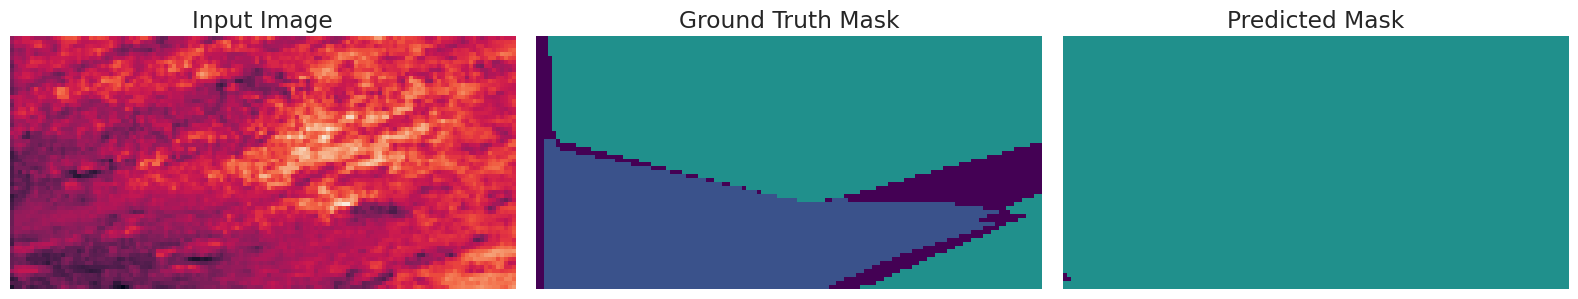

126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.6526 - mean_iou: 0.3061 - val_loss: 0.7447 - val_mean_iou: 0.1145
Epoch 12: Learning rate is 9.999999747378752e-05
Epoch 12/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.6508 - mean_iou: 0.2967 - val_loss: 0.6623 - val_mean_iou: 0.2422
Epoch 13: Learning rate is 9.999999747378752e-05
Epoch 13/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.6454 - mean_iou: 0.3000 - val_loss: 0.6786 - val_mean_iou: 0.1723
Epoch 14: Learning rate is 9.999999747378752e-05
Epoch 14/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.6391 - mean_iou: 0.3098 - val_loss: 0.6777 - val_mean_iou: 0.2002
Epoch 15: Learning rate is 9.999999747378752e-05
Epoch 15/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.6353 - mean_iou: 0.3161 - val_loss: 0.6657 - val_mean_iou: 0.2417
Epoch 16: Learning rate is 9.999999747378752e-05
Epoch 16/1000
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.6342 - mean_iou: 0.3111

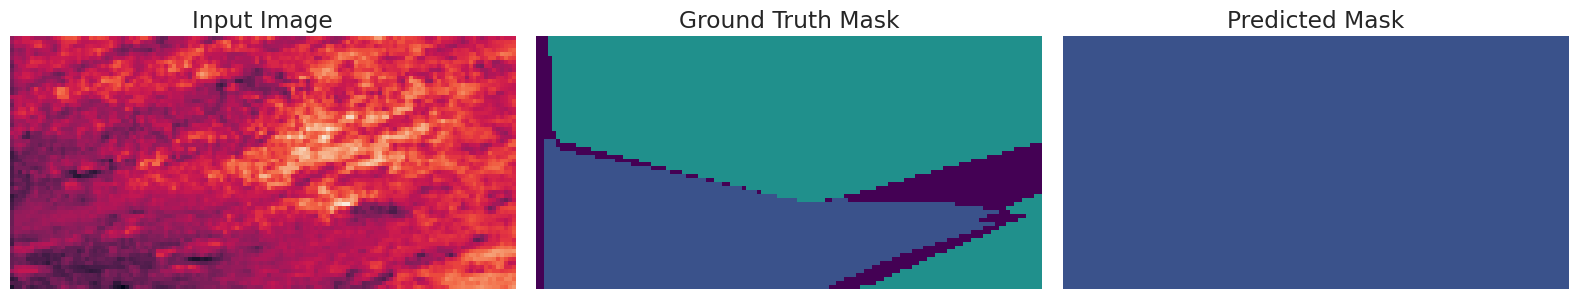

126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.6341 - mean_iou: 0.3111 - val_loss: 0.6610 - val_mean_iou: 0.2049
Epoch 17: Learning rate is 9.999999747378752e-05
Epoch 17/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.6277 - mean_iou: 0.3244 - val_loss: 0.6620 - val_mean_iou: 0.2081
Epoch 18: Learning rate is 9.999999747378752e-05
Epoch 18/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.6330 - mean_iou: 0.3090 - val_loss: 0.6758 - val_mean_iou: 0.1734
Epoch 19: Learning rate is 9.999999747378752e-05
Epoch 19/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.6276 - mean_iou: 0.3238 - val_loss: 0.6865 - val_mean_iou: 0.1733
Epoch 20: Learning rate is 9.999999747378752e-05
Epoch 20/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.6226 - mean_iou: 0.3275 - val_loss: 0.6591 - val_mean_iou: 0.2168
Epoch 21: Learning rate is 9.999999747378752e-05
Epoch 21/1000
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.6186 - mean_iou: 0.3373

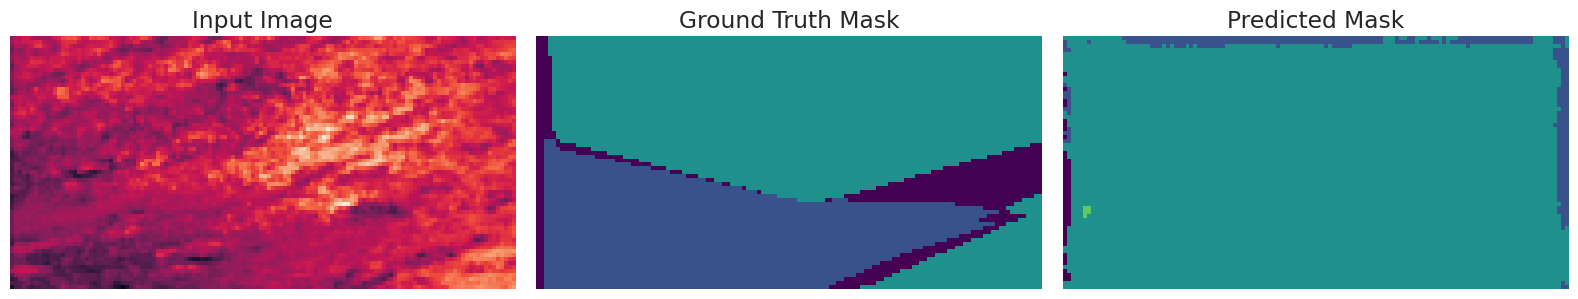

126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 0.6186 - mean_iou: 0.3372 - val_loss: 0.6551 - val_mean_iou: 0.2781
Epoch 22: Learning rate is 9.999999747378752e-05
Epoch 22/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.6174 - mean_iou: 0.3434 - val_loss: 0.6716 - val_mean_iou: 0.2445
Epoch 23: Learning rate is 9.999999747378752e-05
Epoch 23/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.6152 - mean_iou: 0.3415 - val_loss: 0.6536 - val_mean_iou: 0.2454
Epoch 24: Learning rate is 9.999999747378752e-05
Epoch 24/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.6114 - mean_iou: 0.3506 - val_loss: 0.6582 - val_mean_iou: 0.2547
Epoch 25: Learning rate is 9.999999747378752e-05
Epoch 25/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.6172 - mean_iou: 0.3286 - val_loss: 0.6554 - val_mean_iou: 0.2391
Epoch 26: Learning rate is 9.999999747378752e-05
Epoch 26/1000
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.6163 - mean_iou: 0.3337

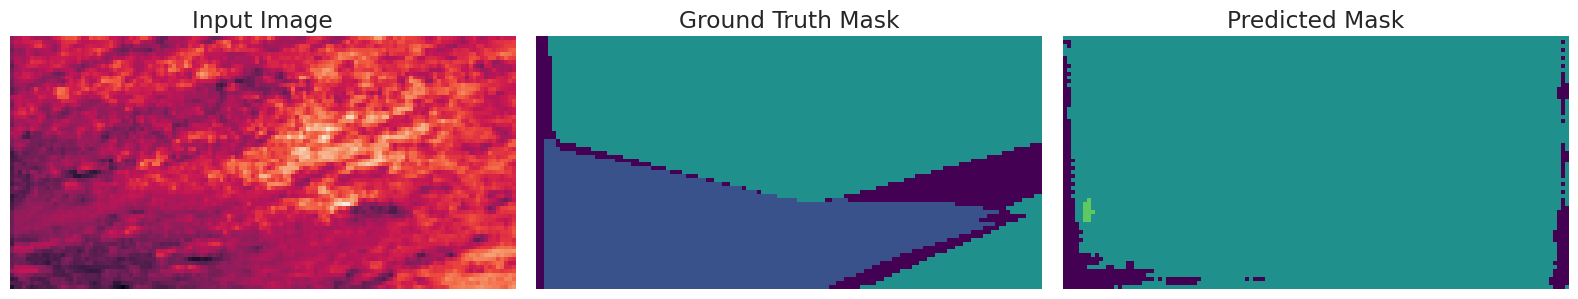

126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 0.6163 - mean_iou: 0.3337 - val_loss: 0.6800 - val_mean_iou: 0.1643
Epoch 27: Learning rate is 9.999999747378752e-05
Epoch 27/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.6120 - mean_iou: 0.3393 - val_loss: 0.6796 - val_mean_iou: 0.1277
Epoch 28: Learning rate is 9.999999747378752e-05
Epoch 28/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.6049 - mean_iou: 0.3590 - val_loss: 0.6497 - val_mean_iou: 0.2428
Epoch 29: Learning rate is 9.999999747378752e-05
Epoch 29/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.6081 - mean_iou: 0.3533 - val_loss: 0.6686 - val_mean_iou: 0.1813
Epoch 30: Learning rate is 9.999999747378752e-05
Epoch 30/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.6056 - mean_iou: 0.3558 - val_loss: 0.6615 - val_mean_iou: 0.2030
Epoch 31: Learning rate is 9.999999747378752e-05
Epoch 31/1000
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.6067 - mean_iou: 0.3574

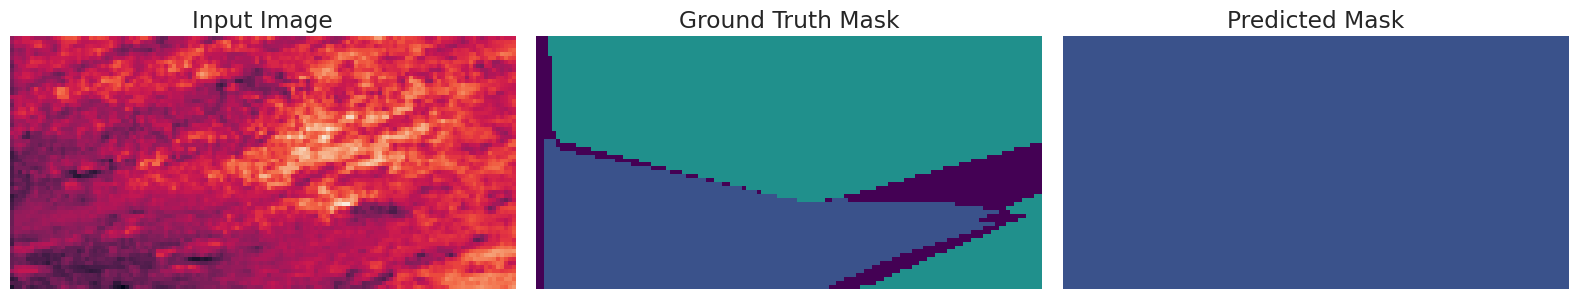

126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.6067 - mean_iou: 0.3573 - val_loss: 0.6510 - val_mean_iou: 0.2098
Epoch 32: Learning rate is 9.999999747378752e-05
Epoch 32/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.6061 - mean_iou: 0.3524 - val_loss: 0.6910 - val_mean_iou: 0.1917
Epoch 33: Learning rate is 9.999999747378752e-05
Epoch 33/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.6031 - mean_iou: 0.3603 - val_loss: 0.6493 - val_mean_iou: 0.2257
Epoch 34: Learning rate is 9.999999747378752e-05
Epoch 34/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.6063 - mean_iou: 0.3517 - val_loss: 0.6537 - val_mean_iou: 0.2360
Epoch 35: Learning rate is 9.999999747378752e-05
Epoch 35/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.6014 - mean_iou: 0.3669 - val_loss: 0.6503 - val_mean_iou: 0.2335
Epoch 36: Learning rate is 9.999999747378752e-05
Epoch 36/1000
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.6001 - mean_iou: 0.3658

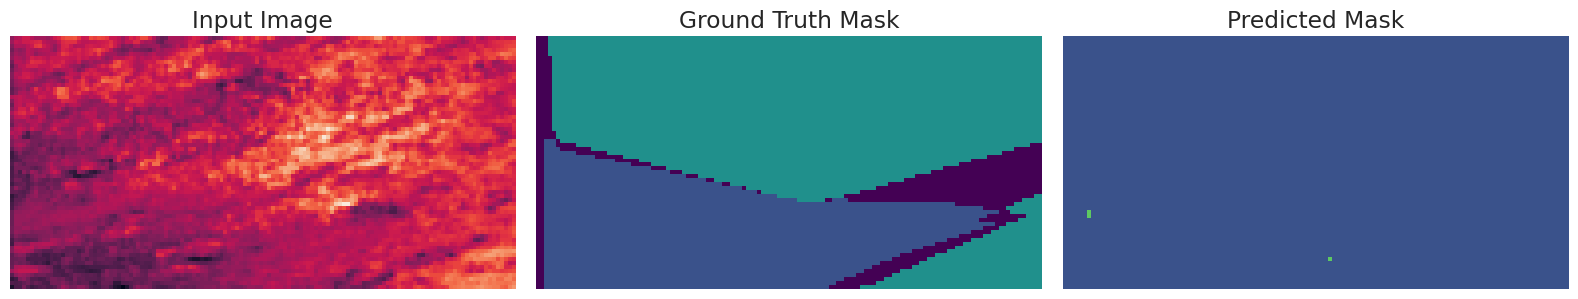

126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 0.6001 - mean_iou: 0.3656 - val_loss: 0.6508 - val_mean_iou: 0.2392
Epoch 37: Learning rate is 9.999999747378752e-05
Epoch 37/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.5975 - mean_iou: 0.3706 - val_loss: 0.6654 - val_mean_iou: 0.1628
Epoch 38: Learning rate is 9.999999747378752e-05
Epoch 38/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.5993 - mean_iou: 0.3684 - val_loss: 0.6486 - val_mean_iou: 0.2525
Epoch 39: Learning rate is 9.999999747378752e-05
Epoch 39/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.5982 - mean_iou: 0.3707 - val_loss: 0.6449 - val_mean_iou: 0.2494
Epoch 40: Learning rate is 9.999999747378752e-05
Epoch 40/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.5976 - mean_iou: 0.3669 - val_loss: 0.6608 - val_mean_iou: 0.1767
Epoch 41: Learning rate is 9.999999747378752e-05
Epoch 41/1000
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.5969 - mean_iou: 0.3716

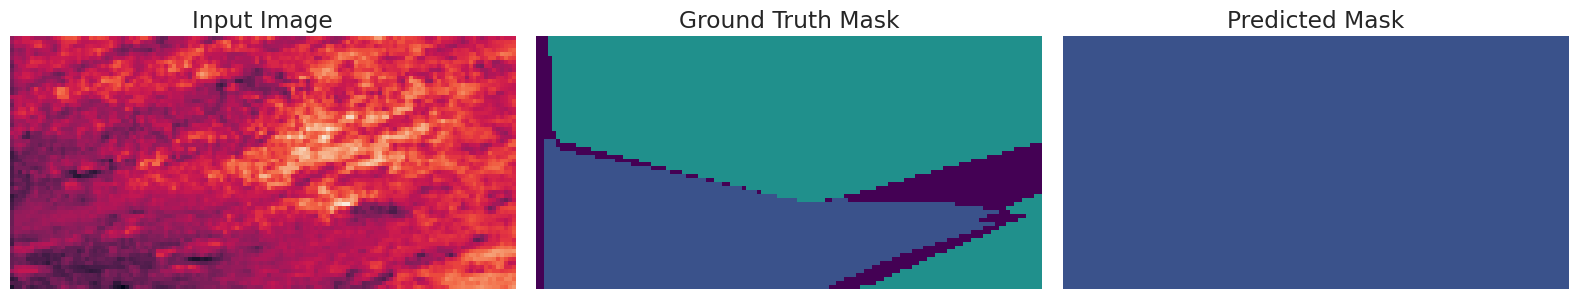

126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.5969 - mean_iou: 0.3716 - val_loss: 0.6497 - val_mean_iou: 0.2235
Epoch 42: Learning rate is 9.999999747378752e-05
Epoch 42/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.5972 - mean_iou: 0.3724 - val_loss: 0.6602 - val_mean_iou: 0.1927
Epoch 43: Learning rate is 9.999999747378752e-05
Epoch 43/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.5928 - mean_iou: 0.3767 - val_loss: 0.6502 - val_mean_iou: 0.2457
Epoch 44: Learning rate is 9.999999747378752e-05
Epoch 44/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.5928 - mean_iou: 0.3822 - val_loss: 0.6564 - val_mean_iou: 0.1977
Epoch 45: Learning rate is 9.999999747378752e-05
Epoch 45/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.5945 - mean_iou: 0.3730 - val_loss: 0.6698 - val_mean_iou: 0.2002
Epoch 46: Learning rate is 9.999999747378752e-05
Epoch 46/1000
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.5949 - mean_iou: 0.3742

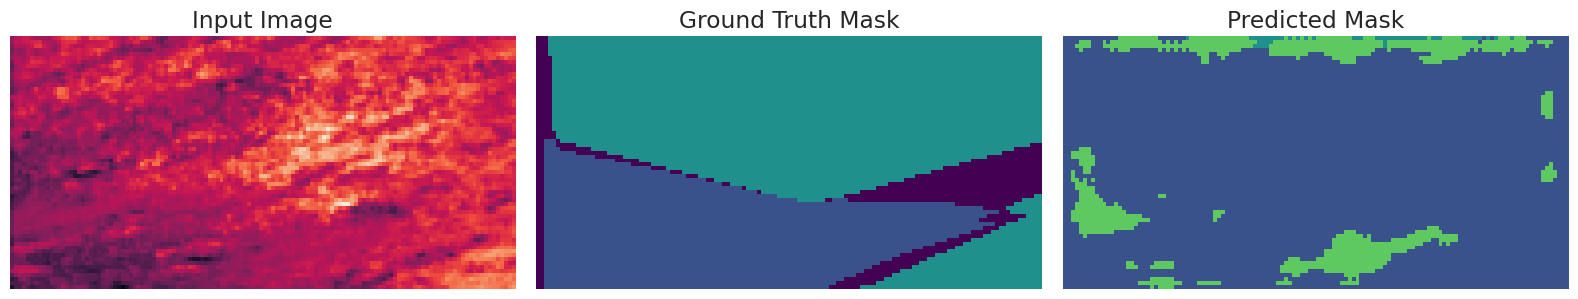

126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 0.5949 - mean_iou: 0.3742 - val_loss: 0.6452 - val_mean_iou: 0.2440
Epoch 47: Learning rate is 9.999999747378752e-05
Epoch 47/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.5932 - mean_iou: 0.3765 - val_loss: 0.6435 - val_mean_iou: 0.2572
Epoch 48: Learning rate is 9.999999747378752e-05
Epoch 48/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.5913 - mean_iou: 0.3844 - val_loss: 0.6570 - val_mean_iou: 0.2224
Epoch 49: Learning rate is 9.999999747378752e-05
Epoch 49/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.5889 - mean_iou: 0.3896 - val_loss: 0.6450 - val_mean_iou: 0.2542
Epoch 50: Learning rate is 9.999999747378752e-05
Epoch 50/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.5887 - mean_iou: 0.3886 - val_loss: 0.6560 - val_mean_iou: 0.1910
Epoch 51: Learning rate is 9.999999747378752e-05
Epoch 51/1000
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.5890 - mean_iou: 0.3889

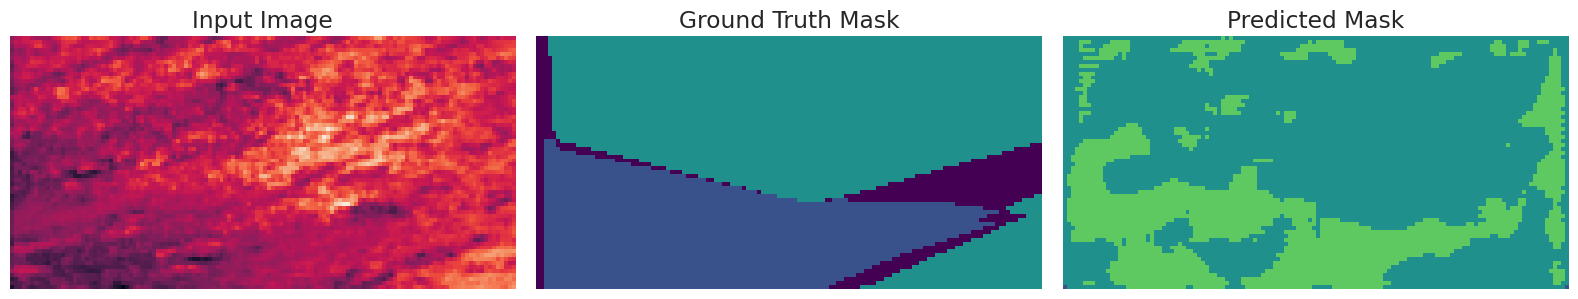

126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - loss: 0.5890 - mean_iou: 0.3888 - val_loss: 0.6551 - val_mean_iou: 0.2575
Epoch 52: Learning rate is 9.999999747378752e-05
Epoch 52/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.5895 - mean_iou: 0.3893 - val_loss: 0.6549 - val_mean_iou: 0.1943
Epoch 53: Learning rate is 9.999999747378752e-05
Epoch 53/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.5875 - mean_iou: 0.3901 - val_loss: 0.6609 - val_mean_iou: 0.1869
Epoch 54: Learning rate is 9.999999747378752e-05
Epoch 54/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.5868 - mean_iou: 0.3930 - val_loss: 0.6505 - val_mean_iou: 0.2502
Epoch 55: Learning rate is 9.999999747378752e-05
Epoch 55/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.5896 - mean_iou: 0.3880 - val_loss: 0.6599 - val_mean_iou: 0.1916
Epoch 56: Learning rate is 9.999999747378752e-05
Epoch 56/1000
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.5872 - mean_iou: 0.3941

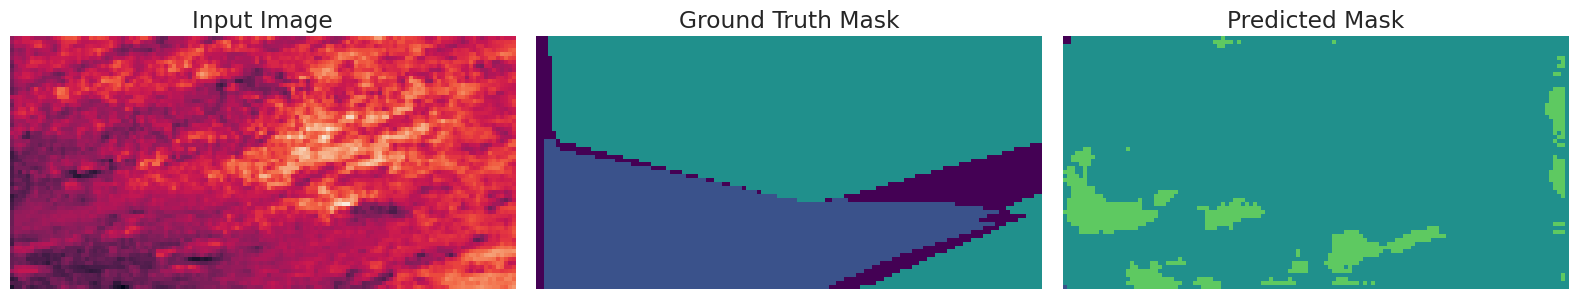

126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 0.5872 - mean_iou: 0.3939 - val_loss: 0.6564 - val_mean_iou: 0.2442
Epoch 57: Learning rate is 9.999999747378752e-05
Epoch 57/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.5860 - mean_iou: 0.3985 - val_loss: 0.6799 - val_mean_iou: 0.1828
Epoch 58: Learning rate is 9.999999747378752e-05
Epoch 58/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.5814 - mean_iou: 0.4068 - val_loss: 0.6592 - val_mean_iou: 0.2313
Epoch 59: Learning rate is 9.999999747378752e-05
Epoch 59/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.5854 - mean_iou: 0.4021 - val_loss: 0.6701 - val_mean_iou: 0.1752
Epoch 60: Learning rate is 9.999999747378752e-05
Epoch 60/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.5830 - mean_iou: 0.4025 - val_loss: 0.6451 - val_mean_iou: 0.2606
Epoch 61: Learning rate is 9.999999747378752e-05
Epoch 61/1000
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.5820 - mean_iou: 0.4092

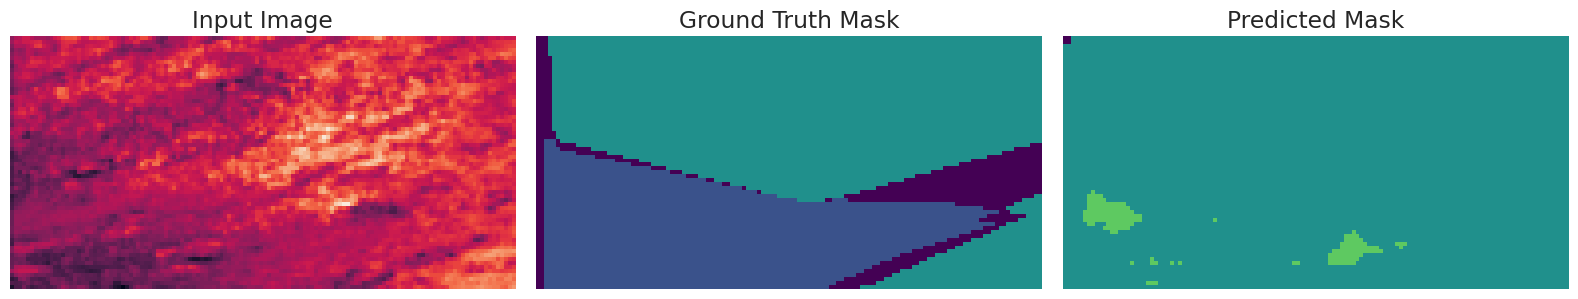

126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 0.5820 - mean_iou: 0.4090 - val_loss: 0.6672 - val_mean_iou: 0.2501
Epoch 62: Learning rate is 9.999999747378752e-05
Epoch 62/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.5813 - mean_iou: 0.4109 - val_loss: 0.6345 - val_mean_iou: 0.2789
Epoch 63: Learning rate is 9.999999747378752e-05
Epoch 63/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.5801 - mean_iou: 0.4104 - val_loss: 0.6483 - val_mean_iou: 0.2330
Epoch 64: Learning rate is 9.999999747378752e-05
Epoch 64/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.5800 - mean_iou: 0.4112 - val_loss: 0.6590 - val_mean_iou: 0.2132
Epoch 65: Learning rate is 9.999999747378752e-05
Epoch 65/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.5821 - mean_iou: 0.4092 - val_loss: 0.6623 - val_mean_iou: 0.2378
Epoch 66: Learning rate is 9.999999747378752e-05
Epoch 66/1000
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.5777 - mean_iou: 0.4260

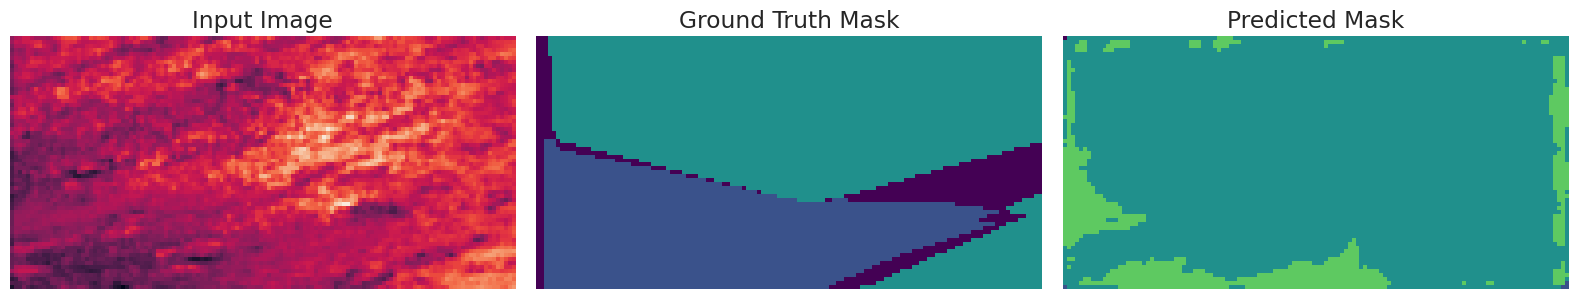

126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 0.5777 - mean_iou: 0.4258 - val_loss: 0.6507 - val_mean_iou: 0.2674
Epoch 67: Learning rate is 9.999999747378752e-05
Epoch 67/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.5721 - mean_iou: 0.4398 - val_loss: 0.6497 - val_mean_iou: 0.2253
Epoch 68: Learning rate is 9.999999747378752e-05
Epoch 68/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.5764 - mean_iou: 0.4264 - val_loss: 0.6497 - val_mean_iou: 0.2540
Epoch 69: Learning rate is 9.999999747378752e-05
Epoch 69/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.5743 - mean_iou: 0.4340 - val_loss: 0.6448 - val_mean_iou: 0.2543
Epoch 70: Learning rate is 9.999999747378752e-05
Epoch 70/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.5763 - mean_iou: 0.4314 - val_loss: 0.7318 - val_mean_iou: 0.1278
Epoch 71: Learning rate is 9.999999747378752e-05
Epoch 71/1000
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.5805 - mean_iou: 0.4090

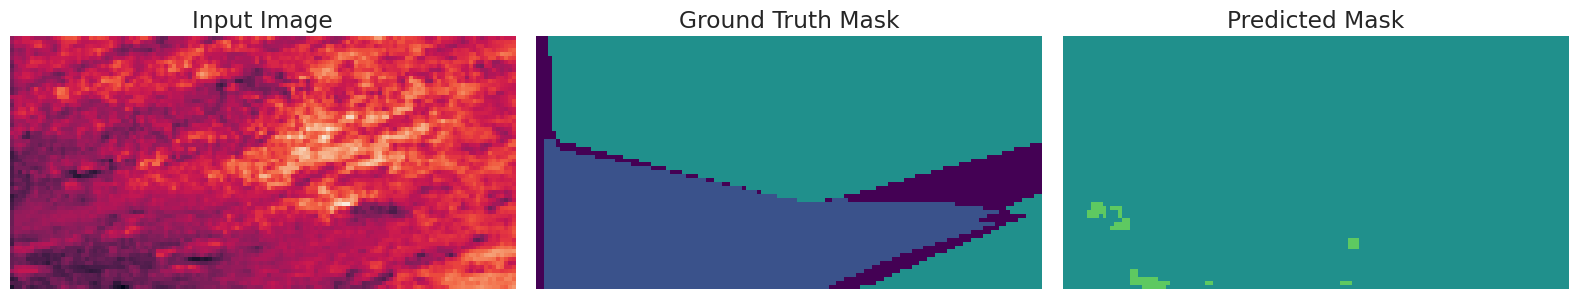

126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 0.5805 - mean_iou: 0.4091 - val_loss: 0.6984 - val_mean_iou: 0.1802
Epoch 72: Learning rate is 9.999999747378752e-05
Epoch 72/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.5768 - mean_iou: 0.4248 - val_loss: 0.6599 - val_mean_iou: 0.2218
Epoch 73: Learning rate is 9.999999747378752e-05
Epoch 73/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.5741 - mean_iou: 0.4338 - val_loss: 0.6584 - val_mean_iou: 0.2395
Epoch 74: Learning rate is 9.999999747378752e-05
Epoch 74/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.5750 - mean_iou: 0.4276 - val_loss: 0.6583 - val_mean_iou: 0.2215
Epoch 75: Learning rate is 9.999999747378752e-05
Epoch 75/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.5725 - mean_iou: 0.4375 - val_loss: 0.7044 - val_mean_iou: 0.1604
Epoch 76: Learning rate is 9.999999747378752e-05
Epoch 76/1000
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.5751 - mean_iou: 0.4299

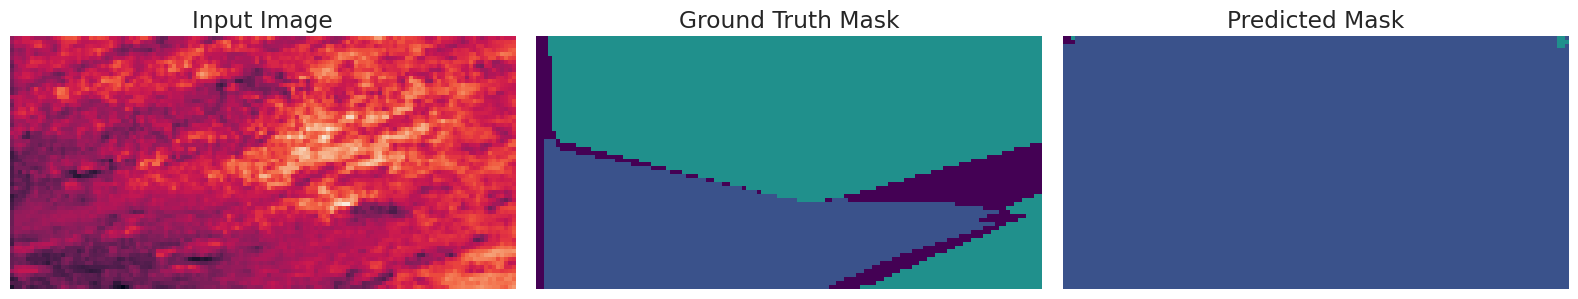

126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 0.5750 - mean_iou: 0.4298 - val_loss: 0.6436 - val_mean_iou: 0.2613
Epoch 77: Learning rate is 9.999999747378752e-05
Epoch 77/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.5755 - mean_iou: 0.4221 - val_loss: 0.6553 - val_mean_iou: 0.2394
Epoch 78: Learning rate is 9.999999747378752e-05
Epoch 78/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.5731 - mean_iou: 0.4301 - val_loss: 0.6581 - val_mean_iou: 0.2558
Epoch 79: Learning rate is 9.999999747378752e-05
Epoch 79/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.5768 - mean_iou: 0.4185 - val_loss: 0.6501 - val_mean_iou: 0.2516
Epoch 80: Learning rate is 9.999999747378752e-05
Epoch 80/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.5728 - mean_iou: 0.4342 - val_loss: 0.6542 - val_mean_iou: 0.2377
Epoch 81: Learning rate is 9.999999747378752e-05
Epoch 81/1000
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.5719 - mean_iou: 0.4315

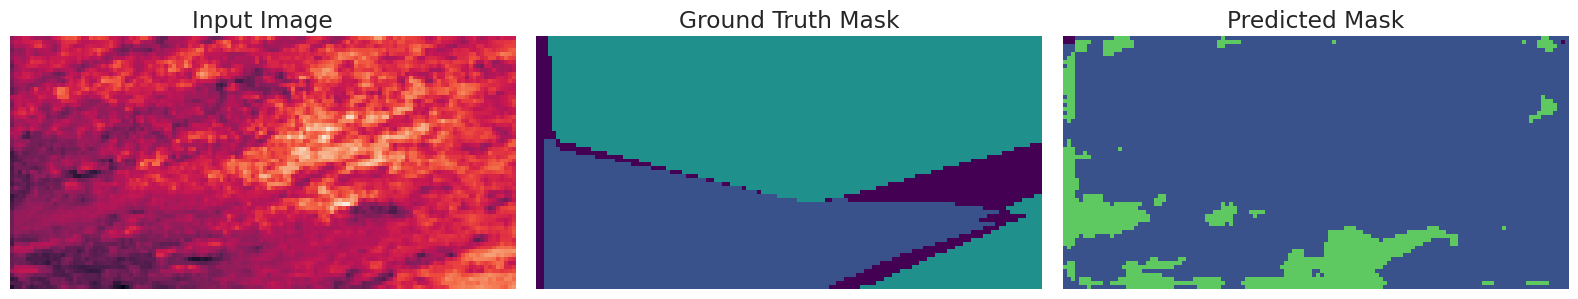

126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 0.5719 - mean_iou: 0.4315 - val_loss: 0.6441 - val_mean_iou: 0.2575
Epoch 82: Learning rate is 9.999999747378752e-05
Epoch 82/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.5697 - mean_iou: 0.4427 - val_loss: 0.6847 - val_mean_iou: 0.1966
Epoch 83: Learning rate is 9.999999747378752e-05
Epoch 83/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.5727 - mean_iou: 0.4355 - val_loss: 0.6590 - val_mean_iou: 0.2045
Epoch 84: Learning rate is 9.999999747378752e-05
Epoch 84/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.5725 - mean_iou: 0.4324 - val_loss: 0.6786 - val_mean_iou: 0.1968
Epoch 85: Learning rate is 9.999999747378752e-05
Epoch 85/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.5680 - mean_iou: 0.4464 - val_loss: 0.6854 - val_mean_iou: 0.1872
Epoch 86: Learning rate is 9.999999747378752e-05
Epoch 86/1000
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.5695 - mean_iou: 0.4407

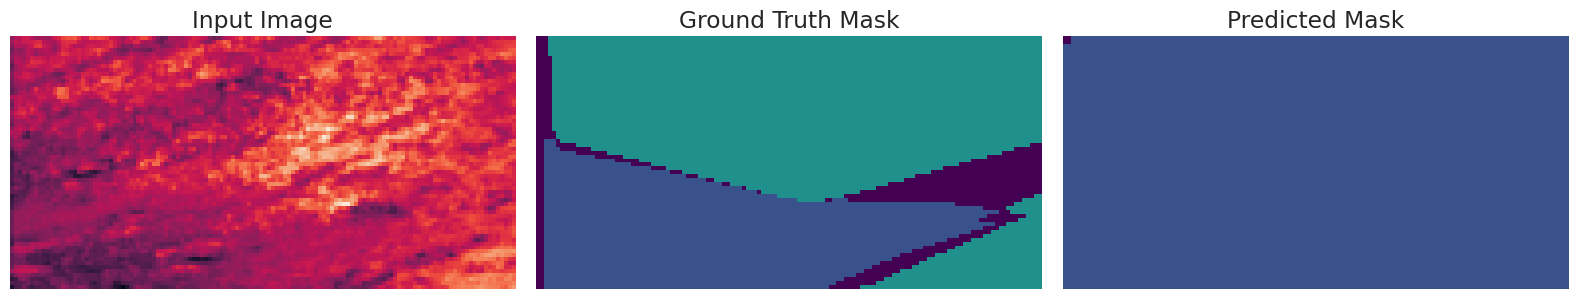

126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 0.5695 - mean_iou: 0.4406 - val_loss: 0.6453 - val_mean_iou: 0.2492
Epoch 87: Learning rate is 9.999999747378752e-05
Epoch 87/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.5670 - mean_iou: 0.4481 - val_loss: 0.6454 - val_mean_iou: 0.2620
Epoch 88: Learning rate is 9.999999747378752e-05
Epoch 88/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.5685 - mean_iou: 0.4487 - val_loss: 0.6395 - val_mean_iou: 0.2755
Epoch 89: Learning rate is 9.999999747378752e-05
Epoch 89/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.5686 - mean_iou: 0.4418 - val_loss: 0.6447 - val_mean_iou: 0.2708
Epoch 90: Learning rate is 9.999999747378752e-05
Epoch 90/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.5706 - mean_iou: 0.4369 - val_loss: 0.6620 - val_mean_iou: 0.1936
Epoch 91: Learning rate is 9.999999747378752e-05
Epoch 91/1000
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.5663 - mean_iou: 0.4602

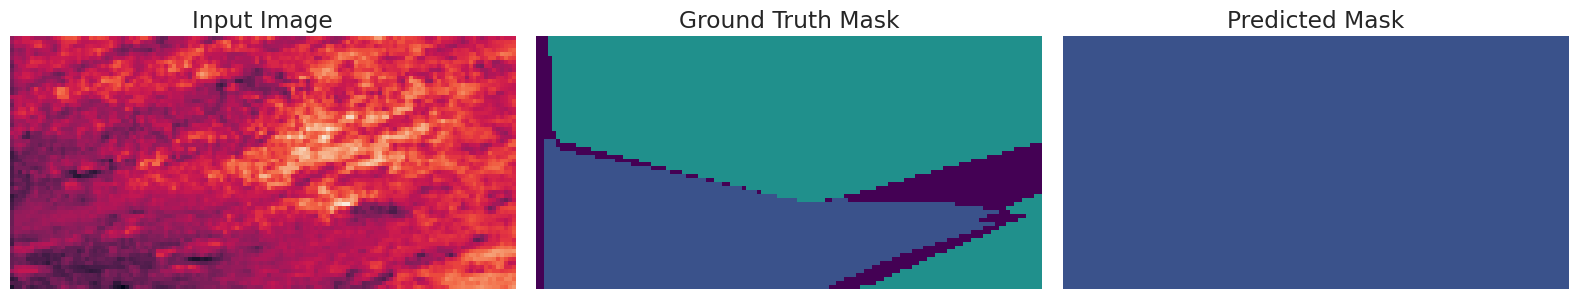

126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.5662 - mean_iou: 0.4602 - val_loss: 0.6583 - val_mean_iou: 0.2027
Epoch 92: Learning rate is 9.999999747378752e-05
Epoch 92/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.5672 - mean_iou: 0.4496 - val_loss: 0.6885 - val_mean_iou: 0.1798
Epoch 93: Learning rate is 9.999999747378752e-05
Epoch 93/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.5686 - mean_iou: 0.4515 - val_loss: 0.6625 - val_mean_iou: 0.2170
Epoch 94: Learning rate is 9.999999747378752e-05
Epoch 94/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.5666 - mean_iou: 0.4566 - val_loss: 0.6471 - val_mean_iou: 0.2223
Epoch 95: Learning rate is 9.999999747378752e-05
Epoch 95/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.5643 - mean_iou: 0.4633 - val_loss: 0.6709 - val_mean_iou: 0.2146
Epoch 96: Learning rate is 9.999999747378752e-05
Epoch 96/1000
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.5671 - mean_iou: 0.4500

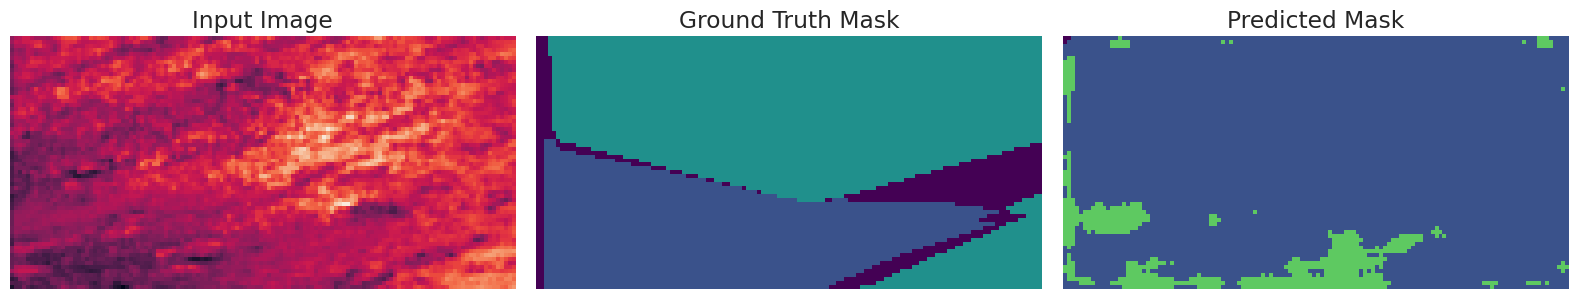

126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 0.5671 - mean_iou: 0.4499 - val_loss: 0.6551 - val_mean_iou: 0.2400
Epoch 97: Learning rate is 9.999999747378752e-05
Epoch 97/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.5627 - mean_iou: 0.4670 - val_loss: 0.6779 - val_mean_iou: 0.2219
Epoch 98: Learning rate is 9.999999747378752e-05
Epoch 98/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.5664 - mean_iou: 0.4548 - val_loss: 0.6486 - val_mean_iou: 0.2390
Epoch 99: Learning rate is 9.999999747378752e-05
Epoch 99/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.5660 - mean_iou: 0.4523 - val_loss: 0.6716 - val_mean_iou: 0.1887
Epoch 100: Learning rate is 9.999999747378752e-05
Epoch 100/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.5638 - mean_iou: 0.4644 - val_loss: 0.6585 - val_mean_iou: 0.2076
Epoch 101: Learning rate is 9.999999747378752e-05
Epoch 101/1000
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.5632 - mean_iou: 0.4631

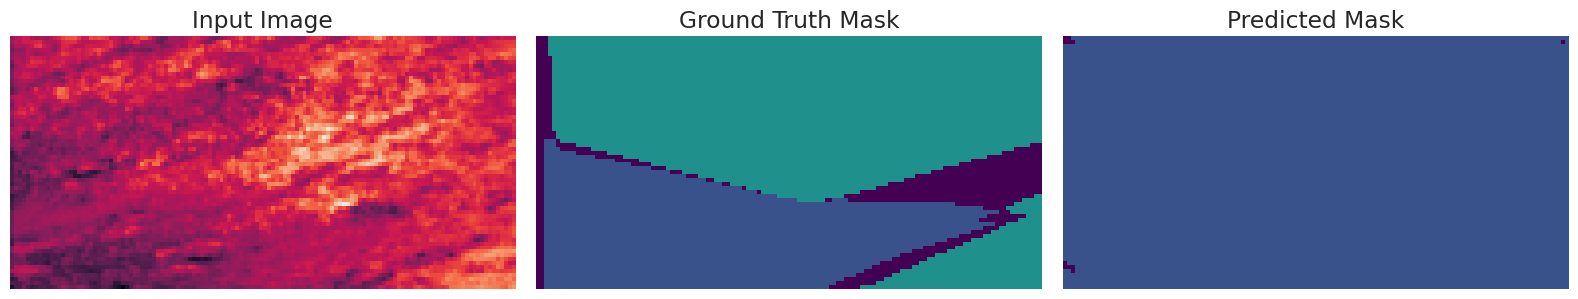

126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 0.5631 - mean_iou: 0.4630 - val_loss: 0.6678 - val_mean_iou: 0.1582
Epoch 102: Learning rate is 9.999999747378752e-05
Epoch 102/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.5647 - mean_iou: 0.4524 - val_loss: 0.6459 - val_mean_iou: 0.2534
Epoch 103: Learning rate is 9.999999747378752e-05
Epoch 103/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.5635 - mean_iou: 0.4590 - val_loss: 0.6947 - val_mean_iou: 0.1429
Epoch 104: Learning rate is 9.999999747378752e-05
Epoch 104/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.5625 - mean_iou: 0.4652 - val_loss: 0.6633 - val_mean_iou: 0.2333
Epoch 105: Learning rate is 9.999999747378752e-05
Epoch 105/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.5641 - mean_iou: 0.4608 - val_loss: 0.6627 - val_mean_iou: 0.2193
Epoch 106: Learning rate is 9.999999747378752e-05
Epoch 106/1000
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.5649 - mean_iou: 0.4525

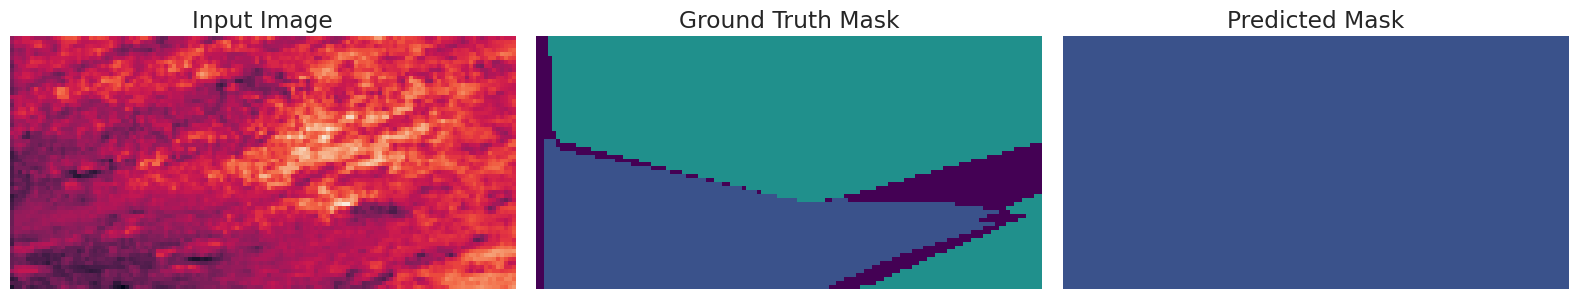

126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 0.5648 - mean_iou: 0.4526 - val_loss: 0.6529 - val_mean_iou: 0.2163
Epoch 107: Learning rate is 9.999999747378752e-05
Epoch 107/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.5603 - mean_iou: 0.4728 - val_loss: 0.6811 - val_mean_iou: 0.1898
Epoch 108: Learning rate is 9.999999747378752e-05
Epoch 108/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.5635 - mean_iou: 0.4626 - val_loss: 0.6483 - val_mean_iou: 0.2689
Epoch 109: Learning rate is 9.999999747378752e-05
Epoch 109/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.5620 - mean_iou: 0.4672 - val_loss: 0.6515 - val_mean_iou: 0.2606
Epoch 110: Learning rate is 9.999999747378752e-05
Epoch 110/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.5642 - mean_iou: 0.4584 - val_loss: 0.6491 - val_mean_iou: 0.2359
Epoch 111: Learning rate is 9.999999747378752e-05
Epoch 111/1000
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.5599 - mean_iou: 0.4696

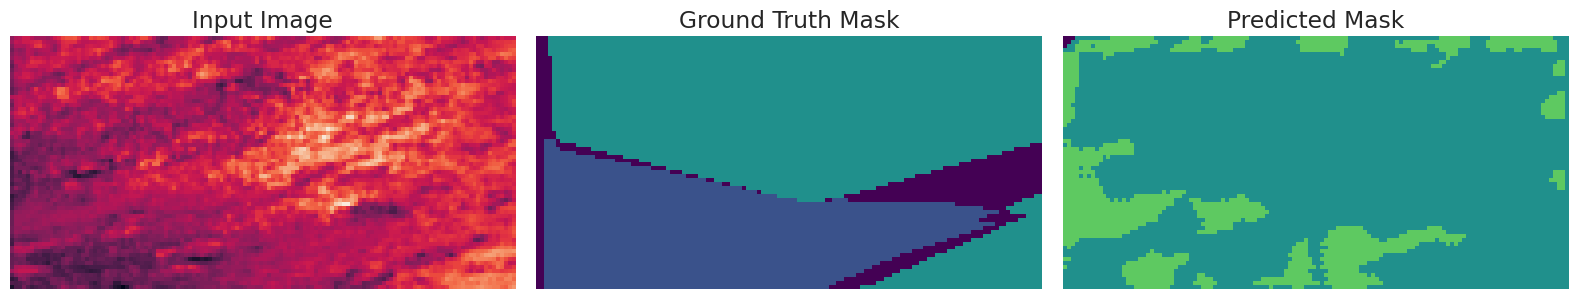

126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 0.5599 - mean_iou: 0.4696 - val_loss: 0.6880 - val_mean_iou: 0.1953
Epoch 112: Learning rate is 9.999999747378752e-05
Epoch 112/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.5609 - mean_iou: 0.4706 - val_loss: 0.6445 - val_mean_iou: 0.2683
Epoch 113: Learning rate is 9.999999747378752e-05
Epoch 113/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.5605 - mean_iou: 0.4719 - val_loss: 0.6456 - val_mean_iou: 0.2562
Epoch 114: Learning rate is 9.999999747378752e-05
Epoch 114/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.5594 - mean_iou: 0.4780 - val_loss: 0.6477 - val_mean_iou: 0.2654
Epoch 115: Learning rate is 9.999999747378752e-05
Epoch 115/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.5607 - mean_iou: 0.4677 - val_loss: 0.6604 - val_mean_iou: 0.2336
Epoch 116: Learning rate is 9.999999747378752e-05
Epoch 116/1000
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.5593 - mean_iou: 0.4728

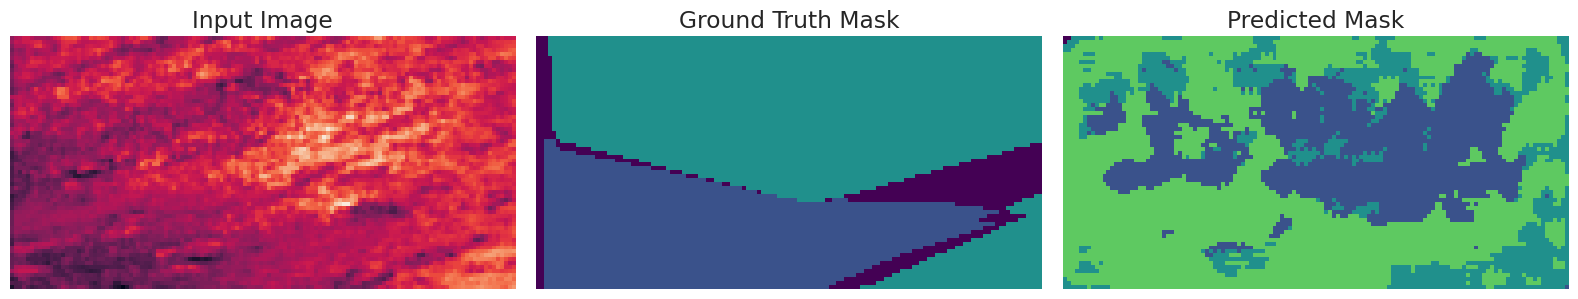

126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 0.5593 - mean_iou: 0.4728 - val_loss: 0.6807 - val_mean_iou: 0.1963
Epoch 117: Learning rate is 9.999999747378752e-05
Epoch 117/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.5592 - mean_iou: 0.4738 - val_loss: 0.6587 - val_mean_iou: 0.1732
Epoch 118: Learning rate is 9.999999747378752e-05
Epoch 118/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.5648 - mean_iou: 0.4599 - val_loss: 0.6521 - val_mean_iou: 0.2476
Epoch 119: Learning rate is 9.999999747378752e-05
Epoch 119/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.5620 - mean_iou: 0.4645 - val_loss: 0.6496 - val_mean_iou: 0.2363
Epoch 120: Learning rate is 9.999999747378752e-05
Epoch 120/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.5609 - mean_iou: 0.4676 - val_loss: 0.6695 - val_mean_iou: 0.2201
Epoch 121: Learning rate is 9.999999747378752e-05
Epoch 121/1000
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.5594 - mean_iou: 0.4721

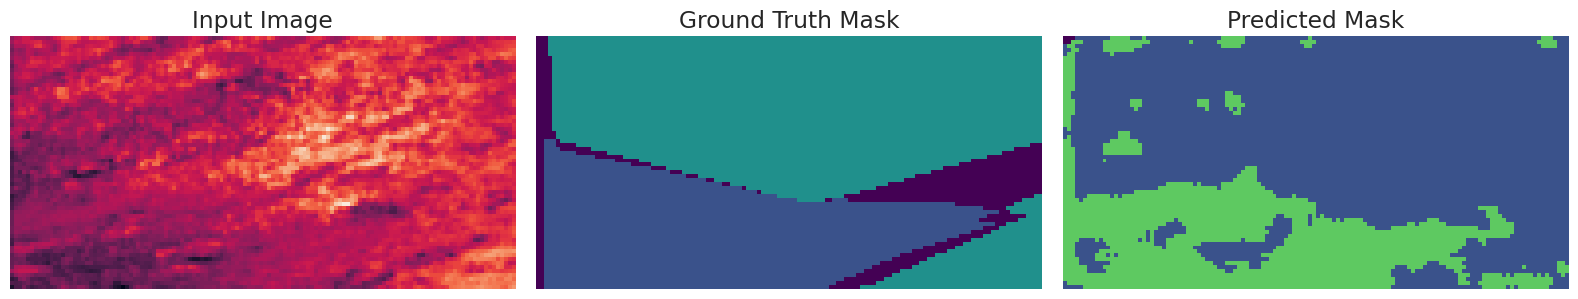

126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.5594 - mean_iou: 0.4722 - val_loss: 0.6570 - val_mean_iou: 0.2462
Epoch 122: Learning rate is 9.999999747378752e-05
Epoch 122/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.5575 - mean_iou: 0.4792 - val_loss: 0.6633 - val_mean_iou: 0.2396
Epoch 123: Learning rate is 9.999999747378752e-05
Epoch 123/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.5607 - mean_iou: 0.4717 - val_loss: 0.6521 - val_mean_iou: 0.2447
Epoch 124: Learning rate is 9.999999747378752e-05
Epoch 124/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.5577 - mean_iou: 0.4860 - val_loss: 0.6573 - val_mean_iou: 0.2325
Epoch 125: Learning rate is 9.999999747378752e-05
Epoch 125/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - loss: 0.5591 - mean_iou: 0.4747 - val_loss: 0.6455 - val_mean_iou: 0.2714
Epoch 126: Learning rate is 9.999999747378752e-05
Epoch 126/1000
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.5579 - mean_iou: 0.4778

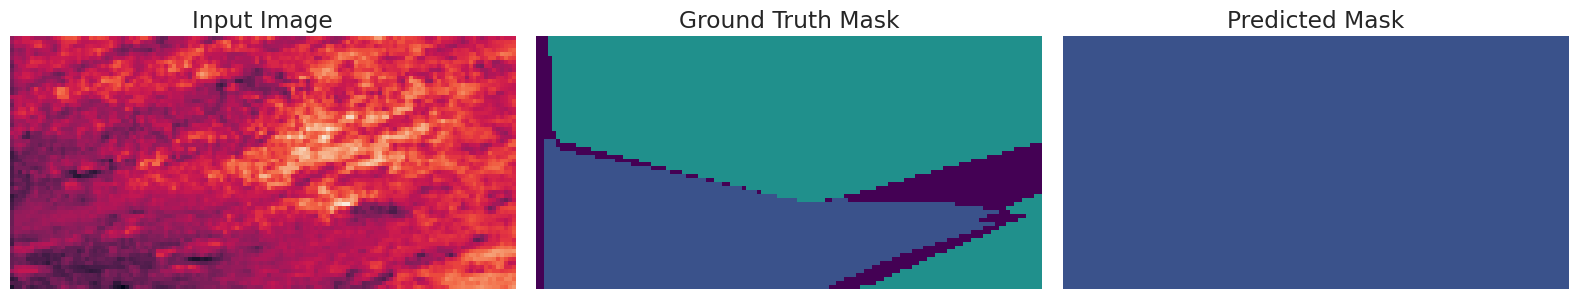

126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 0.5579 - mean_iou: 0.4778 - val_loss: 0.6540 - val_mean_iou: 0.2139
Epoch 127: Learning rate is 9.999999747378752e-05
Epoch 127/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.5578 - mean_iou: 0.4731 - val_loss: 0.6465 - val_mean_iou: 0.2455
Epoch 128: Learning rate is 9.999999747378752e-05
Epoch 128/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.5561 - mean_iou: 0.4838 - val_loss: 0.6491 - val_mean_iou: 0.2619
Epoch 129: Learning rate is 9.999999747378752e-05
Epoch 129/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.5575 - mean_iou: 0.4763 - val_loss: 0.6450 - val_mean_iou: 0.2601
Epoch 130: Learning rate is 9.999999747378752e-05
Epoch 130/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.5562 - mean_iou: 0.4815 - val_loss: 0.6543 - val_mean_iou: 0.2086
Epoch 131: Learning rate is 9.999999747378752e-05
Epoch 131/1000
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.5569 - mean_iou: 0.4794

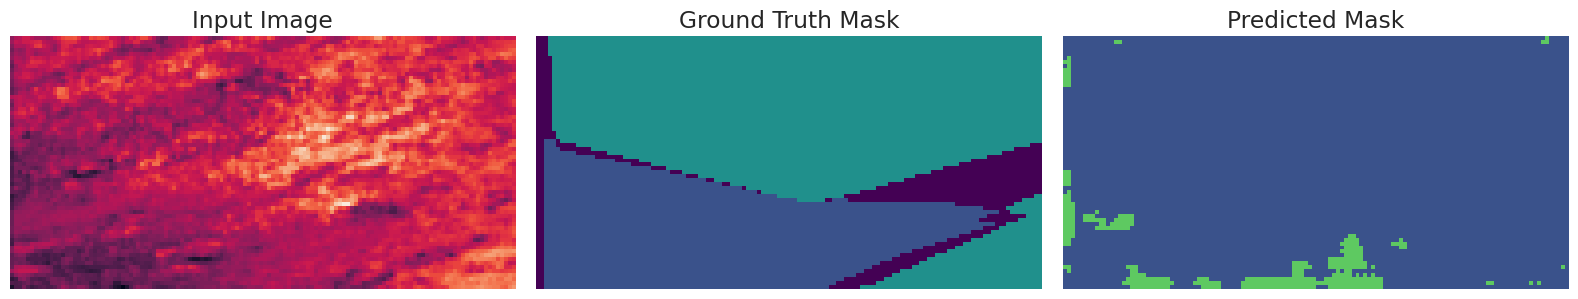

126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 0.5568 - mean_iou: 0.4795 - val_loss: 0.6554 - val_mean_iou: 0.2405
Epoch 132: Learning rate is 9.999999747378752e-05
Epoch 132/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.5562 - mean_iou: 0.4822 - val_loss: 0.6549 - val_mean_iou: 0.2190
Epoch 133: Learning rate is 9.999999747378752e-05
Epoch 133/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.5568 - mean_iou: 0.4823 - val_loss: 0.6482 - val_mean_iou: 0.2535
Epoch 134: Learning rate is 9.999999747378752e-05
Epoch 134/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.5576 - mean_iou: 0.4802 - val_loss: 0.6679 - val_mean_iou: 0.1781
Epoch 135: Learning rate is 9.999999747378752e-05
Epoch 135/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.5551 - mean_iou: 0.4881 - val_loss: 0.6468 - val_mean_iou: 0.2594
Epoch 136: Learning rate is 9.999999747378752e-05
Epoch 136/1000
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.5550 - mean_iou: 0.4857

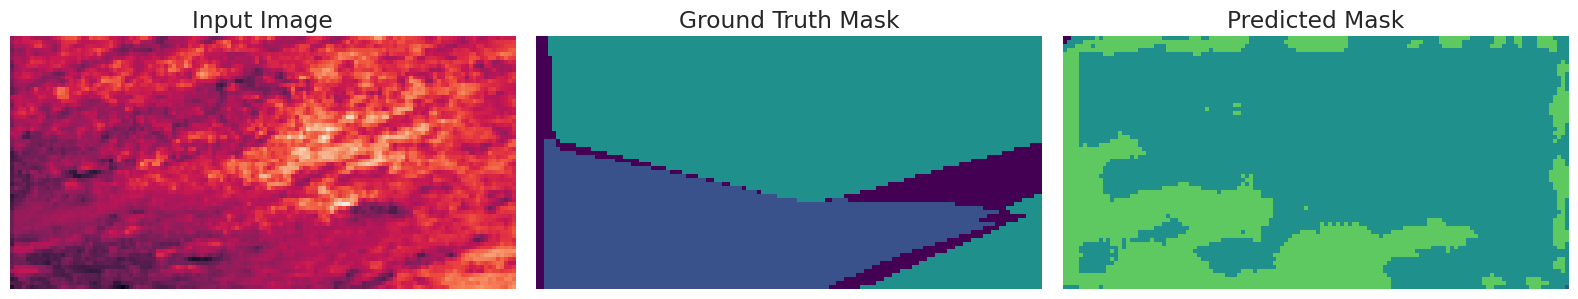

126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 0.5550 - mean_iou: 0.4857 - val_loss: 0.6510 - val_mean_iou: 0.2549
Epoch 137: Learning rate is 9.999999747378752e-05
Epoch 137/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.5551 - mean_iou: 0.4844 - val_loss: 0.6801 - val_mean_iou: 0.1990
Epoch 138: Learning rate is 9.999999747378752e-05
Epoch 138/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.5599 - mean_iou: 0.4703 - val_loss: 0.6488 - val_mean_iou: 0.2431
Epoch 139: Learning rate is 9.999999747378752e-05
Epoch 139/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.5559 - mean_iou: 0.4805 - val_loss: 0.6543 - val_mean_iou: 0.2370
Epoch 140: Learning rate is 9.999999747378752e-05
Epoch 140/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.5575 - mean_iou: 0.4792 - val_loss: 0.6608 - val_mean_iou: 0.2050
Epoch 141: Learning rate is 9.999999747378752e-05
Epoch 141/1000
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.5542 - mean_iou: 0.4897

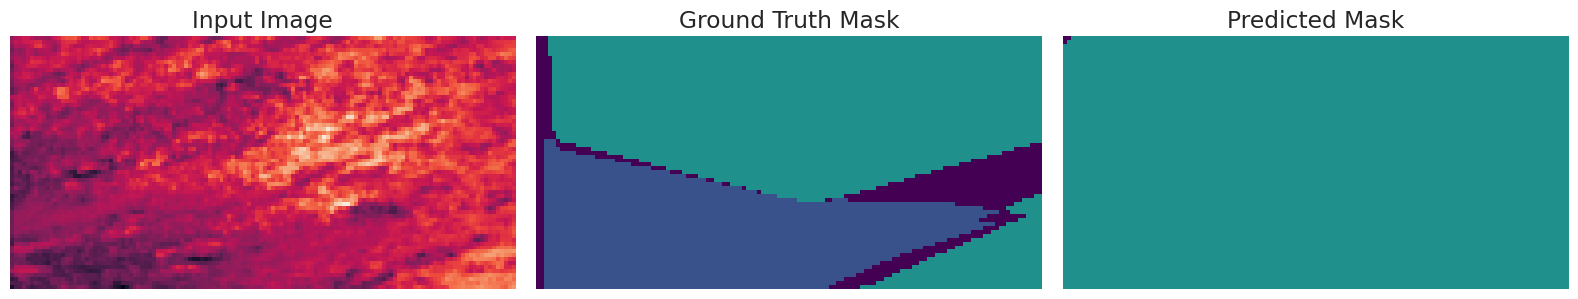

126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 0.5542 - mean_iou: 0.4897 - val_loss: 0.6601 - val_mean_iou: 0.2332
Epoch 142: Learning rate is 9.999999747378752e-05
Epoch 142/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.5546 - mean_iou: 0.4896 - val_loss: 0.6472 - val_mean_iou: 0.2575
Epoch 143: Learning rate is 9.999999747378752e-05
Epoch 143/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.5534 - mean_iou: 0.4897 - val_loss: 0.6826 - val_mean_iou: 0.1878
Epoch 144: Learning rate is 9.999999747378752e-05
Epoch 144/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.5557 - mean_iou: 0.4846 - val_loss: 0.6521 - val_mean_iou: 0.2210
Epoch 145: Learning rate is 9.999999747378752e-05
Epoch 145/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.5531 - mean_iou: 0.4952 - val_loss: 0.6498 - val_mean_iou: 0.2409
Epoch 146: Learning rate is 9.999999747378752e-05
Epoch 146/1000
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.5529 - mean_iou: 0.4956

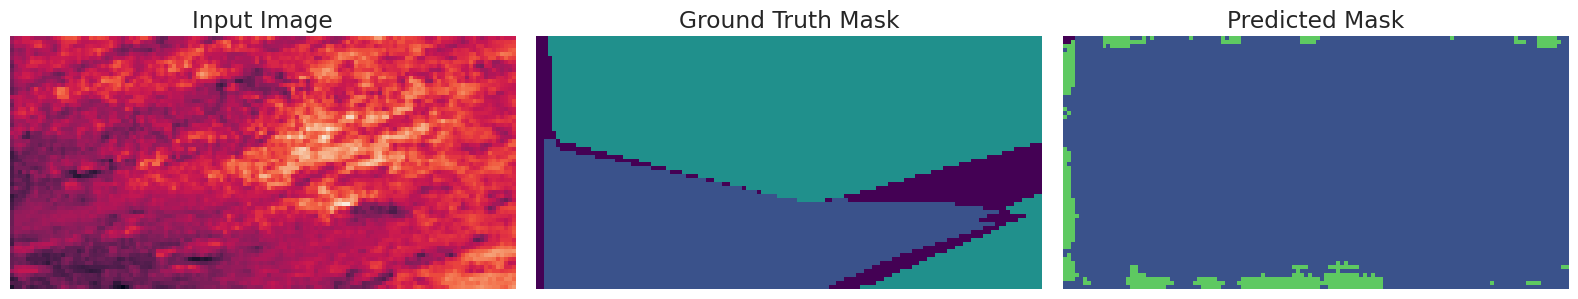

126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.5529 - mean_iou: 0.4956 - val_loss: 0.6729 - val_mean_iou: 0.2166
Epoch 147: Learning rate is 9.999999747378752e-05
Epoch 147/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.5540 - mean_iou: 0.4918 - val_loss: 0.6665 - val_mean_iou: 0.2254
Epoch 148: Learning rate is 9.999999747378752e-05
Epoch 148/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.5535 - mean_iou: 0.4919 - val_loss: 0.6781 - val_mean_iou: 0.2024
Epoch 149: Learning rate is 9.999999747378752e-05
Epoch 149/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.5520 - mean_iou: 0.4991 - val_loss: 0.6722 - val_mean_iou: 0.2027
Epoch 150: Learning rate is 9.999999747378752e-05
Epoch 150/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.5513 - mean_iou: 0.5012 - val_loss: 0.6464 - val_mean_iou: 0.2560
Epoch 151: Learning rate is 9.999999747378752e-05
Epoch 151/1000
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.5534 - mean_iou: 0.4936

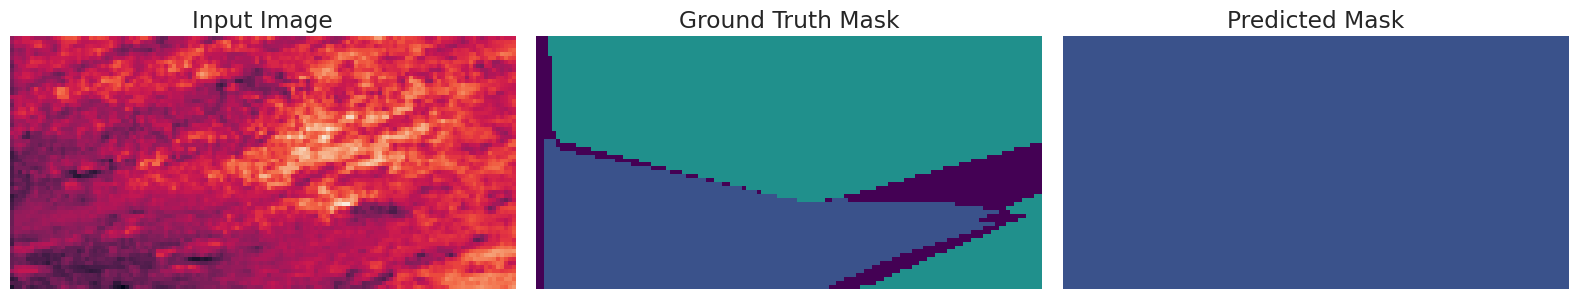

126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.5534 - mean_iou: 0.4937 - val_loss: 0.6545 - val_mean_iou: 0.2480
Epoch 152: Learning rate is 9.999999747378752e-05
Epoch 152/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.5534 - mean_iou: 0.4912 - val_loss: 0.6802 - val_mean_iou: 0.2096
Epoch 153: Learning rate is 9.999999747378752e-05
Epoch 153/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.5513 - mean_iou: 0.4998 - val_loss: 0.6492 - val_mean_iou: 0.2347
Epoch 154: Learning rate is 9.999999747378752e-05
Epoch 154/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.5515 - mean_iou: 0.4987 - val_loss: 0.6675 - val_mean_iou: 0.2335
Epoch 155: Learning rate is 9.999999747378752e-05
Epoch 155/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.5532 - mean_iou: 0.4929 - val_loss: 0.6490 - val_mean_iou: 0.2553
Epoch 156: Learning rate is 9.999999747378752e-05
Epoch 156/1000
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.5539 - mean_iou: 0.4887

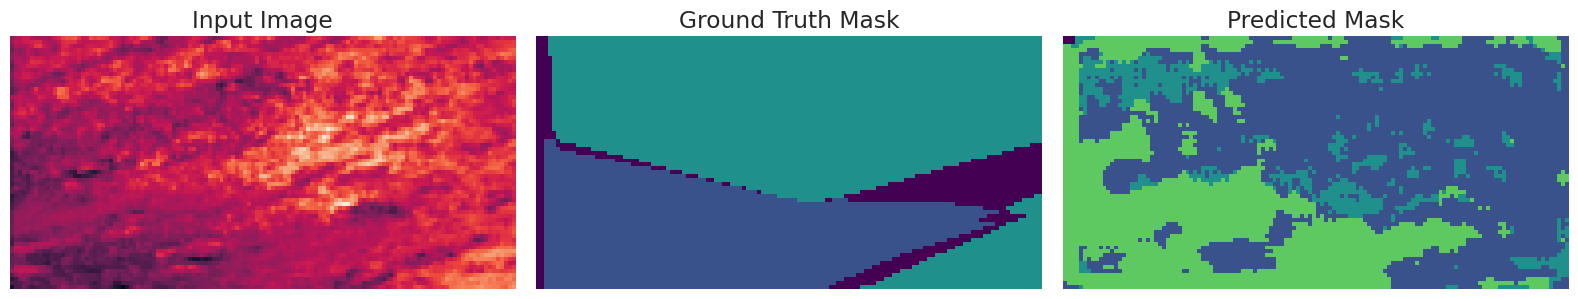

126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.5538 - mean_iou: 0.4888 - val_loss: 0.6450 - val_mean_iou: 0.2649
Epoch 157: Learning rate is 9.999999747378752e-05
Epoch 157/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.5539 - mean_iou: 0.4931 - val_loss: 0.6520 - val_mean_iou: 0.2569
Epoch 158: Learning rate is 9.999999747378752e-05
Epoch 158/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.5508 - mean_iou: 0.4977 - val_loss: 0.6456 - val_mean_iou: 0.2686
Epoch 159: Learning rate is 9.999999747378752e-05
Epoch 159/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.5496 - mean_iou: 0.5052 - val_loss: 0.6710 - val_mean_iou: 0.2102
Epoch 160: Learning rate is 9.999999747378752e-05
Epoch 160/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.5526 - mean_iou: 0.4943 - val_loss: 0.6517 - val_mean_iou: 0.2548
Epoch 161: Learning rate is 9.999999747378752e-05
Epoch 161/1000
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.5509 - mean_iou: 0.5031

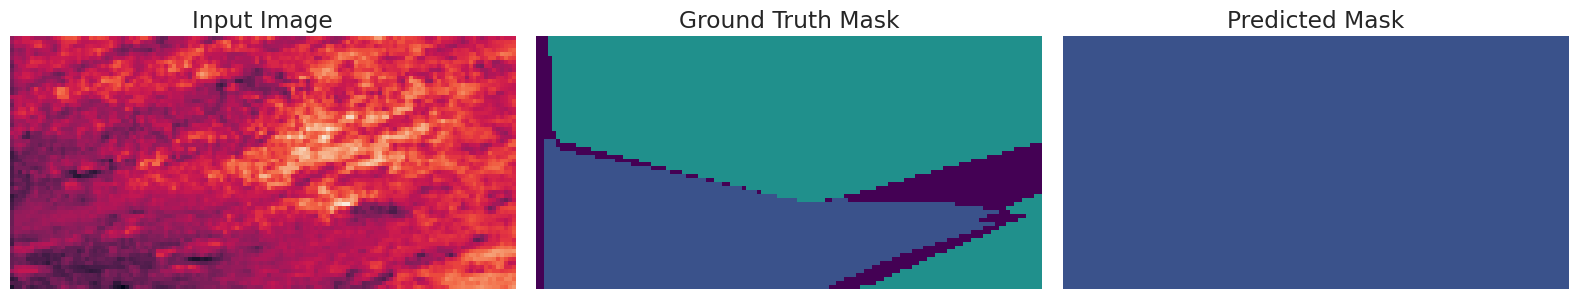

126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.5509 - mean_iou: 0.5031 - val_loss: 0.6592 - val_mean_iou: 0.2016
Epoch 162: Learning rate is 9.999999747378752e-05
Epoch 162/1000
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.5502 - mean_iou: 0.5004 - val_loss: 0.6620 - val_mean_iou: 0.2322
Final validation Mean Intersection Over Union: 27.89%


In [27]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=CALLBACKS
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
MODEL_FILENAME = 'weigths.keras'
model.save(MODEL_FILENAME)

# Training results

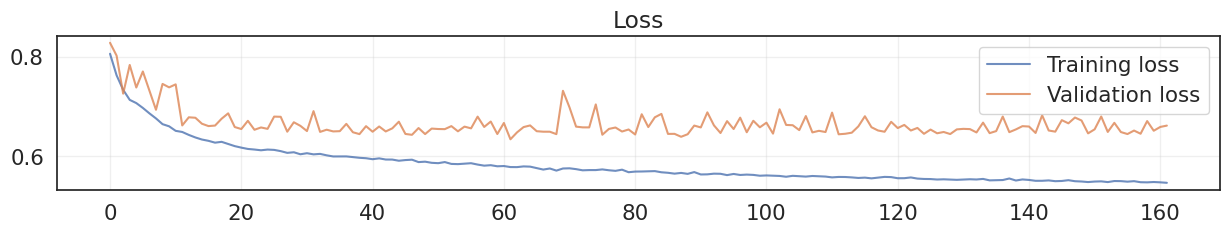

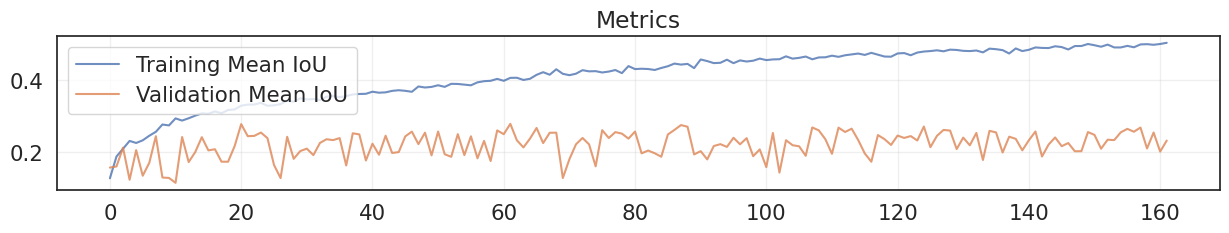

In [28]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation metric
plt.figure(figsize=(15, 2))
plt.plot(history['mean_iou'], label='Training Mean IoU', alpha=.8)
plt.plot(history['val_mean_iou'], label='Validation Mean IoU', alpha=.8)
plt.title('Metrics')
plt.legend()
plt.grid(alpha=.3)
plt.show()

# Test(ate contro il muro)

In [29]:
#import gc

#del model
#gc.collect()

In [30]:
#model = K.models.load_model(MODEL_FILENAME)
#print(f"Model loaded from {MODEL_FILENAME}")

In [31]:
preds = model.predict(img_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step
Predictions shape: (10022, 64, 128)


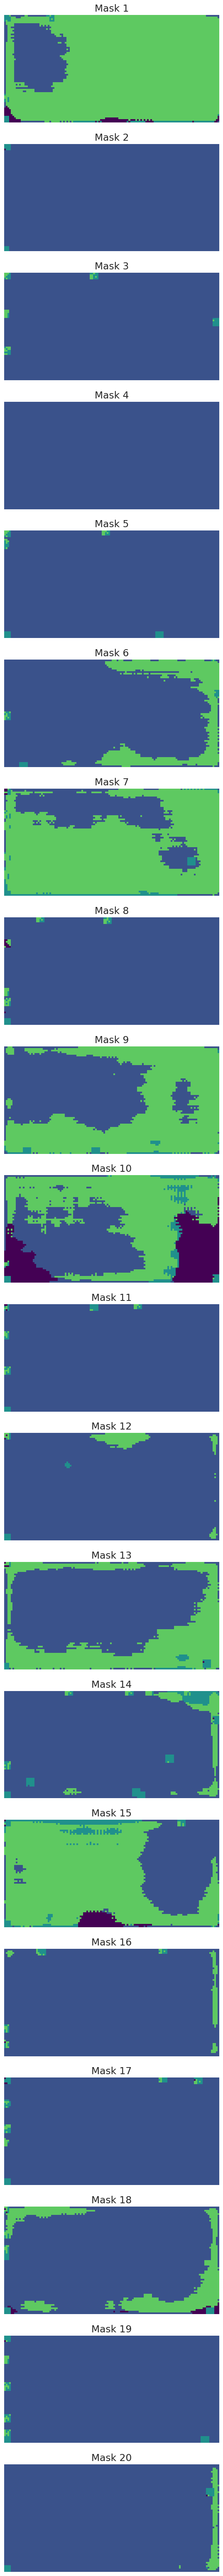

In [32]:
num_samples=20
colormap = create_segmentation_colormap(NUM_CLASSES)
plt.figure(figsize=(15, 4*num_samples))
for i in range(num_samples):
    plt.subplot(num_samples, 1, i+1)
    colored_label = apply_colormap(preds[i], colormap)
    plt.imshow(colored_label)
    plt.title(f'Mask {i+1}')
    plt.axis('off')

In [33]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [34]:
# Create and download the csv submission file
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
SUBMISSION_FILENAME = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(SUBMISSION_FILENAME, index=False)